![STScI Logo](../../../_static/stsci_header.png)

# Sky Matching for HST Mosaics <a id="top"></a>
<hr>


<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook assumes you have created and activated a virtual environment using the requirements file in this notebook's repository. Please make sure you have read the contents of the README file before continuing the notebook. Note that the GIF file "sky_matching_comparison.gif" is one of the downloads needed for this notebook: </b>  </div>

## Learning Goals:
In this tutorial we explore different options for handling the background sky with [`AstroDrizzle`](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api/astrodrizzle.html). <br>
By the end of this notebook you will:<br>
&nbsp;&nbsp;&nbsp;&nbsp;• Download data with [`astroquery`](https://astroquery.readthedocs.io/en/latest/index.html)<br>
&nbsp;&nbsp;&nbsp;&nbsp;• Align data with [`TweakReg`](https://drizzlepac.readthedocs.io/en/latest/user_reprocessing/tweakreg_api.html)<br>
&nbsp;&nbsp;&nbsp;&nbsp;• Compare background sky options using the [`AstroDrizzle`](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api/astrodrizzle.html) parameter `skymethod`

## Table of Contents

[Introduction](#intro) <br>

[1. Download the Observations with `astroquery`](#download) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Check image header data](#check_keywords) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Inspect the alignment](#check_wcs) <br>
[2. Align the visit-level drizzled data with `TweakReg`](#align) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Create a catalog of Gaia DR3 sources](#cat) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Create a catalog of Gaia DR3 sources with Proper Motion Data](#cat_pm) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Run `Tweakreg`](#tweak) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Inspect the shift file and fit quality](#fit_quality) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Overplot matched sources and inspect fit residuals](#overplot) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.6 Rerun `TweakReg` and update the header WCS](#updatehdr) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.7 Run `TweakBack` to propogate the WCS to the FLT files](#tweakback) <br>
[3. Compare `skymethod` options in `AstroDrizzle`](#compare) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 `skymethod = 'localmin'`](#localmin) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 `skymethod = 'match'`](#match) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 `skymethod = 'globalmin+match'`](#globalminmatch) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4 `skymethod = 'globalmin'`](#globalmin) <br>
[4. Compare the MDRIZSKY values for each method](#mdrizsky) <br>
[5. Display the 'sky matched' science mosaic and weight image](#display) <br>
[6. Conclusion](#conclusion) <br>

[Additional Resources](#resources) <br>
[About this notebook](#about) <br>
[Citations](#citations)

## Introduction <a id="intro"></a>

When creating an image mosaic, `AstroDrizzle` has the ability to compute the sky and then either subtract or equalize the background in input images. Users may select the algorithm used for the sky subtraction via the `skymethod` parameter.

There are four methods available in sky matching: `localmin`, `match`, `globalmin`, and `globalmin+match`.

By applying `drizzlepac.sky.sky()`, or using the `skymethod` parameter in the call to `drizzlepac.astrodrizzle.AstroDrizzle()`, AstroDrizzle will update the keyword `MDRIZSKY` in the headers of the input files but it will not change the science data. 

For images of sparse fields with few astronomical sources, the default `skymethod = 'localmin'` may be used, although this method can slightly oversubtract the background.  For images with complicated backgrounds, such as nebulae and large host galaxies, `skymethod = 'match'` is recommended.

For more information on the specifics of this function, please refer to the documentation [here](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api/sky.html#drizzlepac.sky.sky)

Below, each of the four methods is demonstrated using a single example dataset, and differences between the methods is highlighted. 

In [1]:
# All imports needed through out this notebook are included at the beginning. 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import defaultdict
from IPython.display import clear_output 
import glob
import os
import shutil 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas

from astropy.coordinates import SkyCoord
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.units import Quantity
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from drizzlepac import astrodrizzle, tweakback, tweakreg 
from drizzlepac.haputils.astrometric_utils import create_astrometric_catalog


Gaia.MAIN_GAIA_TABLE = 'gaiadr3.gaia_source'   # Change if different data release is desired
Gaia.ROW_LIMIT = 100000

## 1. Download the Observations with `astroquery` <a id="download"></a>

MAST queries may be done using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#observation-criteria-queries"> `query_criteria`</a>, where we specify: <br>

&nbsp;&nbsp;&nbsp;&nbsp;--> obs_id, proposal_id, and filters 

MAST data products may be downloaded by using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data"> `download_products`</a>, where we specify:<br> 

&nbsp;&nbsp;&nbsp;&nbsp;--> products = calibrated (FLT, FLC) or drizzled (DRZ, DRC) files

&nbsp;&nbsp;&nbsp;&nbsp;--> type = standard products (CALxxx) or advanced products (HAP-SVM)

<br>

WFC3/IR observations of the Horsehead Nebula in the F160W filter obtained in HST proposal
program [12812](https://www.stsci.edu/hst-program-info/program/?program=12812)
will be used for this demonstration. 

Nine visits were acquired in a 3x3 mosaic pattern on the sky, with two dither positions per visit in two IR filters. [High level science products](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt) for these datasets were delivered to MAST in 2013, and this notebook is based on that user tutorial but has been updated to align these data to Gaia.

The 18 FLT images <b>ibxl5*_flt.fits</b> have been processed by the HST WFC3 pipeline (calwf3), which includes bias subtraction, dark current correction, cosmic-ray rejection, and flatfielding. The 9 DRZ files <b>ibxl5*_drz.fits</b> have been processed with `AstroDrizzle` to remove distortion and to combine the 2 dithered FLT frames by filter for each vist.

<div class="alert alert-block alert-warning" style="color:black" >  THIS IS A LARGE DOWNLOAD (~400 MB). Depending on your connection speed, the next cell may take a few minutes to execute. </div>

In [2]:
obs_ids = ['ibxl5*']
props = ['12812']
filts = ['F160W']

obsTable = Observations.query_criteria(obs_id=obs_ids, proposal_id=props, filters=filts)
products = Observations.get_product_list(obsTable)

data_prod = ['FLT', 'DRZ']     # ['FLC','FLT','DRC','DRZ']                  
data_type = ['CALWF3']         # ['CALACS','CALWF3','CALWP2','HAP-SVM']    

Observations.download_products(products, download_dir='./science',
                               productSubGroupDescription=data_prod, 
                               project=data_type)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<Table length=27>
                       Local Path                        Status  Message  URL  
                         str55                            str8    object object
------------------------------------------------------- -------- ------- ------
./science/mastDownload/HST/ibxl50clq/ibxl50clq_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl50cqq/ibxl50cqq_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl51eoq/ibxl51eoq_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl51etq/ibxl51etq_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl52k0q/ibxl52k0q_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl52k5q/ibxl52k5q_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl53kxq/ibxl53kxq_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl53l9q/ibxl53l9q_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl54bgq/ibxl54bgq_flt.fits COMPLETE    None   None
                                                    ...      ...     ...    ...
./science/mastDownload/HST/ibxl58svq/ibxl58svq_flt.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl50030/ibxl50030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl51030/ibxl51030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl52030/ibxl52030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl53030/ibxl53030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl54030/ibxl54030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl55030/ibxl55030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl56030/ibxl56030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl57030/ibxl57030_drz.fits COMPLETE    None   None
./science/mastDownload/HST/ibxl58030/ibxl58030_drz.fits COMPLETE    None   None

Move the files to the local working directory

In [3]:
files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in files:
    root = os.path.basename(im)
    os.rename(im, './' + root)
    
if os.path.exists('./science'):
    shutil.rmtree('science/')

### 1.1 Check image header data <a id="check_keywords"></a>

Here we will look at important keywords in the image headers.

In [4]:
files = sorted(glob.glob('*fl?.fits'))
keywords_ext0 = ["ROOTNAME", "ASN_ID", "TARGNAME", "DETECTOR", "FILTER", "EXPTIME", 
                 "RA_TARG", "DEC_TARG", "POSTARG1", "POSTARG2", "DATE-OBS"]
keywords_ext1 = ["ORIENTAT"]
data = []

for file in files:
    path_data = []
    for keyword in keywords_ext0:
        path_data.append(fits.getval(file, keyword, ext=0))
    for keyword in keywords_ext1:
        path_data.append(fits.getval(file, keyword, ext=1))
    data.append(path_data)
    
keywords = keywords_ext0 + keywords_ext1
table = Table(np.array(data), names=keywords, dtype=['str', 'str', 'str', 'str', 'str', 'f8', 'f8', 'f8', 'f8', 'f8', 'str', 'f8'])
table['EXPTIME'].format = '7.1f' 
table['RA_TARG'].format = table['DEC_TARG'].format = '7.4f'
table['POSTARG1'].format = table['POSTARG2'].format = '7.3f' 
table['ORIENTAT'].format = '7.2f'
table.show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

### 1.2 Inspect the Alignment <a id="check_wcs"></a>

Check the active WCS solution in the image header. If the image is aligned to a catalog, list the number of matches and the fit RMS in mas. <br> 
Convert the fit RMS values to pixels for comparison with the alignment results performed later in this notebook.

In [5]:
ext_0_kws = ['DETECTOR']
ext_1_kws = ['WCSNAME', 'NMATCHES', 'RMS_RA', 'RMS_DEC']

det_scale = {'IR': 0.1283, 'UVIS': 0.0396, 'WFC': 0.05}                  # plate scale (arcsec/pixel)

format_dict = {}
col_dict = defaultdict(list)

for f in sorted(glob.glob('*dr?.fits')):
    col_dict['FILENAME'].append(f)
    hdr0 = fits.getheader(f, 0)
    hdr1 = fits.getheader(f, 1)
    
    for kw in ext_0_kws:                                                # extension 0 keywords
        col_dict[kw].append(hdr0[kw])
    for kw in ext_1_kws:                                                # extension 1 keywords
        if 'RMS' in kw:
            val = np.around(hdr1[kw], 1)
        else: 
            val = hdr1[kw]
        col_dict[kw].append(val)
        
    for kw in ['RMS_RA', 'RMS_DEC']:
        val = np.round(hdr1[kw]/1000./det_scale[hdr0['DETECTOR']], 2)  # convert RMS from mas to pixels
        col_dict[f'{kw}_pix'].append(val)

wcstable = Table(col_dict)
wcstable.show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

<div class="alert alert-block alert-warning" style="color:black" > <b> Note that there are different WCS solutions for each visit, with Gaia eDR3 as the reference catalog for all but two which were fit to GSC v2.4.2 and which have a much larger fit rms values (>0.5 pixels). Since the WCS solutions are inconsistent for this target, we wish to realign the data to use a common reference catalog.</b></div>

## 2. Align the visit-level drizzled data with `TweakReg` <a id="align"></a>

Here we will use `TweakReg` to align the DRZ files to Gaia DR3 and then use `TweakBack` to propagate those solutions back to the FLT image headers prior to combining with `AstroDrizzle`. 

### 2.1 Create a catalog of Gaia DR3 sources  <a id="cat"></a>

This method uses the RA/Dec of the first image and a radius of 5'.

In [6]:
RA = table['RA_TARG'][0]
Dec = table['DEC_TARG'][0]

coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(5., u.arcmin)

gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
gaia_query

INFO: Query finished. [astroquery.utils.tap.core]


<Table length=183>
    solution_id             designation          ...         dist        
                                                 ...                     
       int64                   object            ...       float64       
------------------- ---------------------------- ... --------------------
1636148068921376768 Gaia DR3 3216469053418858496 ... 0.009486679186673242
1636148068921376768 Gaia DR3 3216469057714526080 ... 0.013011650487557274
1636148068921376768 Gaia DR3 3216467855123686016 ... 0.017083879996516314
1636148068921376768 Gaia DR3 3216469019060675328 ... 0.017945489552972947
1636148068921376768 Gaia DR3 3216468611037930624 ...  0.01836293659726027
1636148068921376768 Gaia DR3 3216468675465488256 ... 0.020028009828231417
1636148068921376768 Gaia DR3 3216469023354785408 ... 0.020043830041751424
1636148068921376768 Gaia DR3 3216467855122414464 ... 0.023539736369753695
1636148068921376768 Gaia DR3 3216468164360052992 ...  0.02782140743048771
                ...                          ... ...                  ...
1636148068921376768 Gaia DR3 3216456065439222912 ...    0.080839193349907
1636148068921376768 Gaia DR3 3216472558112887808 ...  0.08112646296289025
1636148068921376768 Gaia DR3 3216444937178204160 ...  0.08121814053391099
1636148068921376768 Gaia DR3 3216468782835372032 ...  0.08200148643415694
1636148068921376768 Gaia DR3 3216455691775435392 ...  0.08219069174617054
1636148068921376768 Gaia DR3 3216469847988496640 ...  0.08234330900782977
1636148068921376768 Gaia DR3 3216470840133093504 ...  0.08269446496314736
1636148068921376768 Gaia DR3 3216443872025058816 ...  0.08286217986852269
1636148068921376768 Gaia DR3 3216455653128695936 ...  0.08287548585527736

In [7]:
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query.write('gaia_no_pm.cat', format='ascii.commented_header', overwrite=True)
reduced_query

<Table length=183>
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
     float64            float64           float32    
----------------- ------------------- ---------------
85.25078206874738  -2.444257621037541       19.836756
85.24865858921503  -2.441354584616136       17.722948
85.25474417063919  -2.470084090608095       17.202978
85.26833524857398 -2.4416029853336667       20.263578
 85.2386085747217  -2.462292300986681       20.337946
85.23467309871081 -2.4498085573057633        20.23374
85.27075582329469  -2.441307234608435       19.156166
85.25578005166672 -2.4765054474694934          20.352
85.27451682697576  -2.472305714228985       20.950966
              ...                 ...             ...
85.31116982575814 -2.5106681948456453       19.762535
85.18852621317357  -2.405656267543347       19.284597
85.19030586577739 -2.5028819323642013        17.53799
85.17292618358479 -2.4623957493034743       19.089468
85.30495708910514 -2.5178904392586623       20.880104
85.33205874915119  -2.425249860759321       20.068647
85.30747238821475   -2.38949359231377       19.625616
85.24559042309376  -2.535389226550673       20.522165
85.29328038861492  -2.526244532656098       19.140984

### 2.2 Create a catalog of Gaia DR3 sources with Proper Motion Data  <a id="cat_pm"></a>

This method uses the image FLT footprints and gives 161 sources, compared to 183 with the prior method.

In [8]:
pm_cat = create_astrometric_catalog(sorted(glob.glob('*flt.fits')))
pm_cat.write('gaia_pm.cat', overwrite=True, format='ascii.no_header')
len(pm_cat)

2025309190027 INFO src=drizzlepac.haputils.astrometric_utils- Getting catalog using: 
    http://gsss.stsci.edu/webservices/vo/CatalogSearch.aspx?RA=85.25358125611297&DEC=-2.4517874752980333&SR=0.07776447588540084&FORMAT=CSV&CAT=GAIAedr3&MINDET=5&EPOCH=2012.839


2025309190027 INFO src=drizzlepac.haputils.astrometric_utils- Created catalog 'ref_cat.ecsv' with 161  sources


161

### 2.3 Run `TweakReg` <a id="tweak"></a>

Next we run `TweakReg` on the visit-level drizzled (DRZ) images and align to the Gaia catalog with proper motion data. 

Because the fit RMS values for the MAST products were large for some visits, we allow for a larger than usual search radius of 1". We also set the `conv_width` value slightly higher than the recommended value of 2.5 for WFC3/IR data in order to use barely resolved sources for alignment.

Setting up logfile :  tweakreg.log


TweakReg Version 3.10.0 started at: 19:00:27.744 (05/11/2025) 


Version Information


--------------------


Python Version 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:46:25) [GCC 14.3.0]


numpy Version -> 2.3.4 


astropy Version -> 7.1.1 


stwcs Version -> 1.7.5 


photutils Version -> 2.3.0 


Finding shifts for: 


    ibxl50030_drz.fits


    ibxl51030_drz.fits


    ibxl52030_drz.fits


    ibxl53030_drz.fits


    ibxl54030_drz.fits


    ibxl55030_drz.fits


    ibxl56030_drz.fits


    ibxl57030_drz.fits


    ibxl58030_drz.fits


===  Source finding for image 'ibxl50030_drz.fits':


  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 19:00:27.789 (05/11/2025)


     Found 75 objects.


===  FINAL number of objects in image 'ibxl50030_drz.fits': 75


===  Source finding for image 'ibxl51030_drz.fits':


  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 19:00:27.882 (05/11/2025)


     Found 83 objects.


===  FINAL number of objects in image 'ibxl51030_drz.fits': 83


===  Source finding for image 'ibxl52030_drz.fits':


  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 19:00:27.972 (05/11/2025)


     Found 87 objects.


===  FINAL number of objects in image 'ibxl52030_drz.fits': 87


===  Source finding for image 'ibxl53030_drz.fits':


  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 19:00:28.061 (05/11/2025)


     Found 51 objects.


===  FINAL number of objects in image 'ibxl53030_drz.fits': 51


===  Source finding for image 'ibxl54030_drz.fits':


  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 19:00:28.148 (05/11/2025)


     Found 54 objects.


===  FINAL number of objects in image 'ibxl54030_drz.fits': 54


===  Source finding for image 'ibxl55030_drz.fits':


  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 19:00:28.235 (05/11/2025)


     Found 99 objects.


===  FINAL number of objects in image 'ibxl55030_drz.fits': 99


===  Source finding for image 'ibxl56030_drz.fits':


  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 19:00:28.323 (05/11/2025)


     Found 73 objects.


===  FINAL number of objects in image 'ibxl56030_drz.fits': 73


===  Source finding for image 'ibxl57030_drz.fits':


  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 19:00:28.41 (05/11/2025)


     Found 93 objects.


===  FINAL number of objects in image 'ibxl57030_drz.fits': 93


===  Source finding for image 'ibxl58030_drz.fits':


  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 19:00:28.500 (05/11/2025)


     Found 103 objects.


===  FINAL number of objects in image 'ibxl58030_drz.fits': 103


Performing alignment in the projection plane defined by the WCS


derived from 'ibxl50030_drz.fits'


Performing fit for: ibxl50030_drz.fits


Matching sources from 'ibxl50030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.2027, -0.01949 with significance of 6.702 and 9 matches


Found 9 matches for ibxl50030_drz.fits...


Computed  rscale  fit for  ibxl50030_drz.fits : 


XSH: -0.9148  YSH: -0.4434    ROT: 0.022802346    SCALE: 1.000451


FIT XRMS: 0.051      FIT YRMS: 0.082  


FIT RMSE: 0.097      FIT MAE: 0.077  


RMS_RA: 2.3e-06 (deg)   RMS_DEC: 2.6e-06 (deg)


Final solution based on  9  objects.


wrote XY data to:  ibxl50030_drz_catalog_fit.match


Total # points: 9


# of points after clipping: 9


Total # points: 9


# of points after clipping: 9


Performing fit for: ibxl51030_drz.fits


Matching sources from 'ibxl51030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of -0.1306, -0.2973 with significance of 3.909 and 12 matches


Found 12 matches for ibxl51030_drz.fits...


Computed  rscale  fit for  ibxl51030_drz.fits : 


XSH: -0.0950  YSH: -0.6794    ROT: 359.9831545    SCALE: 1.000220


FIT XRMS: 0.039      FIT YRMS: 0.043  


FIT RMSE: 0.058      FIT MAE: 0.056  


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


Final solution based on  12  objects.


wrote XY data to:  ibxl51030_drz_catalog_fit.match


Total # points: 12


# of points after clipping: 12


Total # points: 12


# of points after clipping: 12


Performing fit for: ibxl52030_drz.fits


Matching sources from 'ibxl52030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.2027, -0.6723 with significance of 6.702 and 8 matches


Found 8 matches for ibxl52030_drz.fits...


Computed  rscale  fit for  ibxl52030_drz.fits : 


XSH: -0.5099  YSH: -0.3491    ROT: 0.001210839284    SCALE: 0.999709


FIT XRMS: 0.038      FIT YRMS: 0.018  


FIT RMSE: 0.042      FIT MAE: 0.037  


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 4.3e-07 (deg)


Final solution based on  8  objects.


wrote XY data to:  ibxl52030_drz_catalog_fit.match


Total # points: 8


# of points after clipping: 8


Total # points: 8


# of points after clipping: 8


Performing fit for: ibxl53030_drz.fits


Matching sources from 'ibxl53030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.2027, -0.7973 with significance of 5 and 5 matches


Found 5 matches for ibxl53030_drz.fits...


Computed  rscale  fit for  ibxl53030_drz.fits : 


XSH: -0.2544  YSH: -0.8531    ROT: 359.9968781    SCALE: 1.000185


FIT XRMS: 0.052      FIT YRMS: 0.053  


FIT RMSE: 0.074      FIT MAE: 0.062  


RMS_RA: 2.1e-06 (deg)   RMS_DEC: 1.6e-06 (deg)


Final solution based on  5  objects.


wrote XY data to:  ibxl53030_drz_catalog_fit.match


Total # points: 5


# of points after clipping: 5


Total # points: 5


# of points after clipping: 5


Performing fit for: ibxl54030_drz.fits


Matching sources from 'ibxl54030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.2027, -0.7973 with significance of 7 and 7 matches


Found 7 matches for ibxl54030_drz.fits...


Computed  rscale  fit for  ibxl54030_drz.fits : 


XSH: -0.1959  YSH: -0.9179    ROT: 359.9732889    SCALE: 0.999206


FIT XRMS: 0.033      FIT YRMS: 0.049  


FIT RMSE: 0.059      FIT MAE: 0.049  


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 1.5e-06 (deg)


Final solution based on  7  objects.


wrote XY data to:  ibxl54030_drz_catalog_fit.match


Total # points: 7


# of points after clipping: 7


Total # points: 7


# of points after clipping: 7


Performing fit for: ibxl55030_drz.fits


Matching sources from 'ibxl55030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.02091, -0.4336 with significance of 5.326 and 11 matches


Found 10 matches for ibxl55030_drz.fits...


Computed  rscale  fit for  ibxl55030_drz.fits : 


XSH: -0.0106  YSH: -0.4748    ROT: 359.9953351    SCALE: 1.000175


FIT XRMS: 0.054      FIT YRMS: 0.039  


FIT RMSE: 0.066      FIT MAE: 0.06   


RMS_RA: 2.1e-06 (deg)   RMS_DEC: 1.1e-06 (deg)


Final solution based on  10  objects.


wrote XY data to:  ibxl55030_drz_catalog_fit.match


Total # points: 10


# of points after clipping: 10


Total # points: 10


# of points after clipping: 10


Performing fit for: ibxl56030_drz.fits


Matching sources from 'ibxl56030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.2027, -0.7973 with significance of 5 and 5 matches


Found 5 matches for ibxl56030_drz.fits...


Computed  rscale  fit for  ibxl56030_drz.fits : 


XSH: -0.1540  YSH: -0.5500    ROT: 359.9989578    SCALE: 1.000177


FIT XRMS: 0.14       FIT YRMS: 0.065  


FIT RMSE: 0.15       FIT MAE: 0.12   


RMS_RA: 5.1e-06 (deg)   RMS_DEC: 1.5e-06 (deg)


Final solution based on  5  objects.


wrote XY data to:  ibxl56030_drz_catalog_fit.match


Total # points: 5


# of points after clipping: 5


Total # points: 5


# of points after clipping: 5


Performing fit for: ibxl57030_drz.fits


Matching sources from 'ibxl57030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.2027, 0.2027 with significance of 12 and 12 matches


Found 12 matches for ibxl57030_drz.fits...


Computed  rscale  fit for  ibxl57030_drz.fits : 


XSH: 0.0105  YSH: 0.0838    ROT: 0.001620903605    SCALE: 1.000051


FIT XRMS: 0.038      FIT YRMS: 0.052  


FIT RMSE: 0.064      FIT MAE: 0.055  


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 1.6e-06 (deg)


Final solution based on  12  objects.


wrote XY data to:  ibxl57030_drz_catalog_fit.match


Total # points: 12


# of points after clipping: 12


Total # points: 12


# of points after clipping: 12


Performing fit for: ibxl58030_drz.fits


Matching sources from 'ibxl58030_drz.fits' with sources from reference catalog 'gaia_pm.cat'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.0694, 0.2027 with significance of 12.52 and 15 matches


Found 14 matches for ibxl58030_drz.fits...


Computed  rscale  fit for  ibxl58030_drz.fits : 


XSH: 0.0134  YSH: 0.0520    ROT: 359.998648    SCALE: 0.999998


FIT XRMS: 0.073      FIT YRMS: 0.051  


FIT RMSE: 0.089      FIT MAE: 0.072  


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


Final solution based on  14  objects.


wrote XY data to:  ibxl58030_drz_catalog_fit.match


Total # points: 14


# of points after clipping: 14


Total # points: 14


# of points after clipping: 14


Writing out shiftfile : shift_drz.txt


Trailer file written to:  tweakreg.log


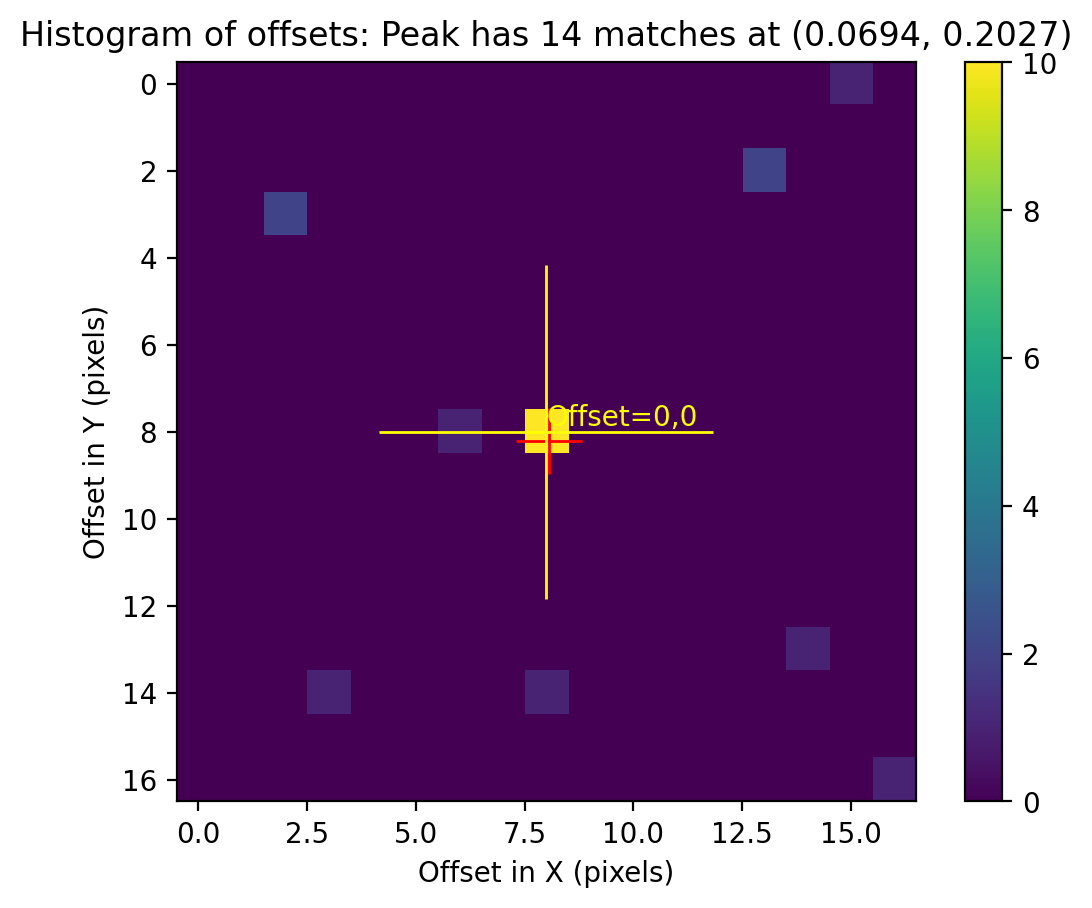

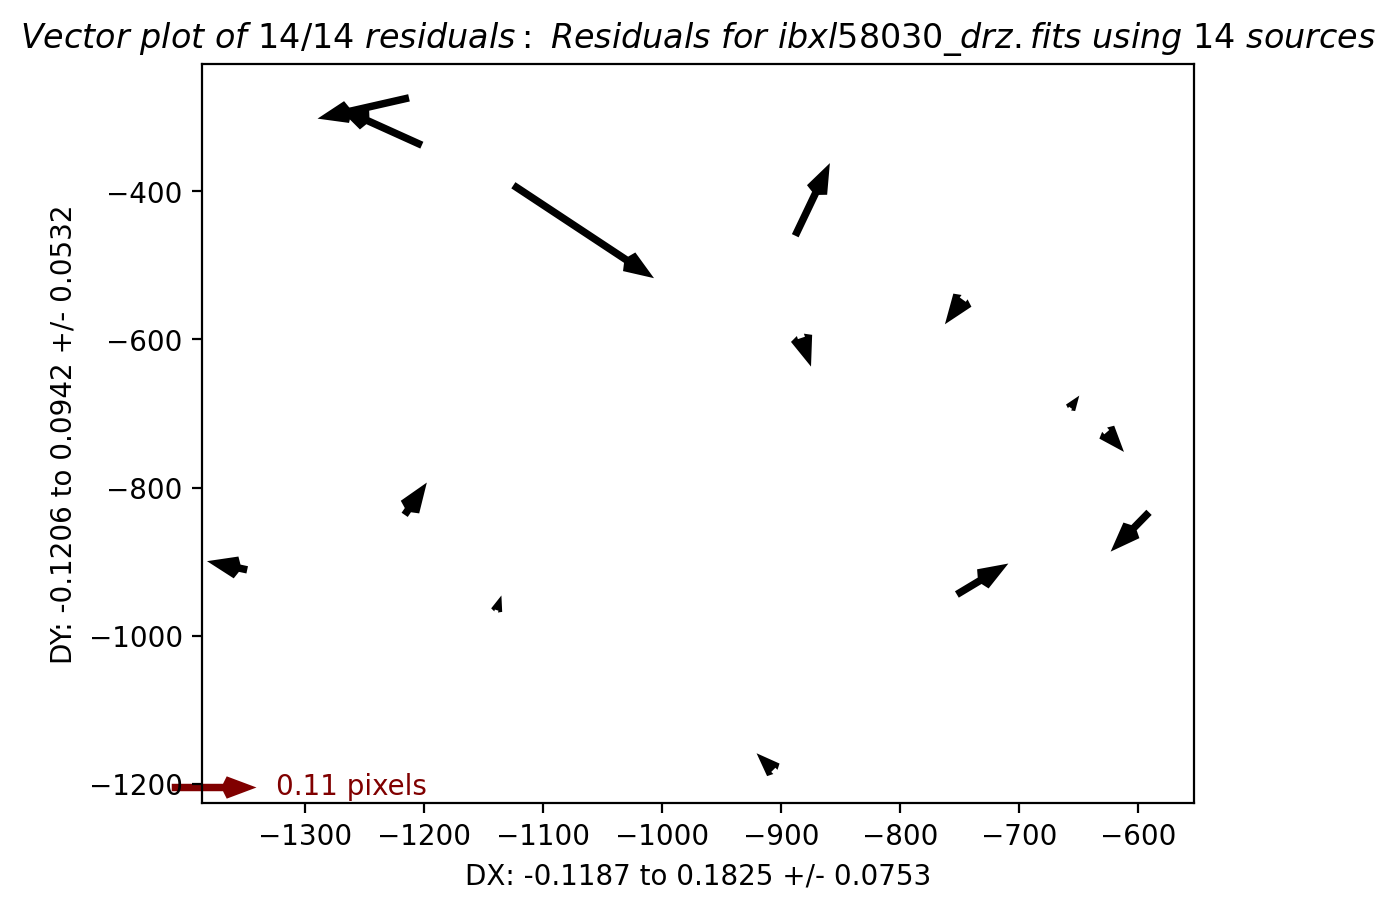

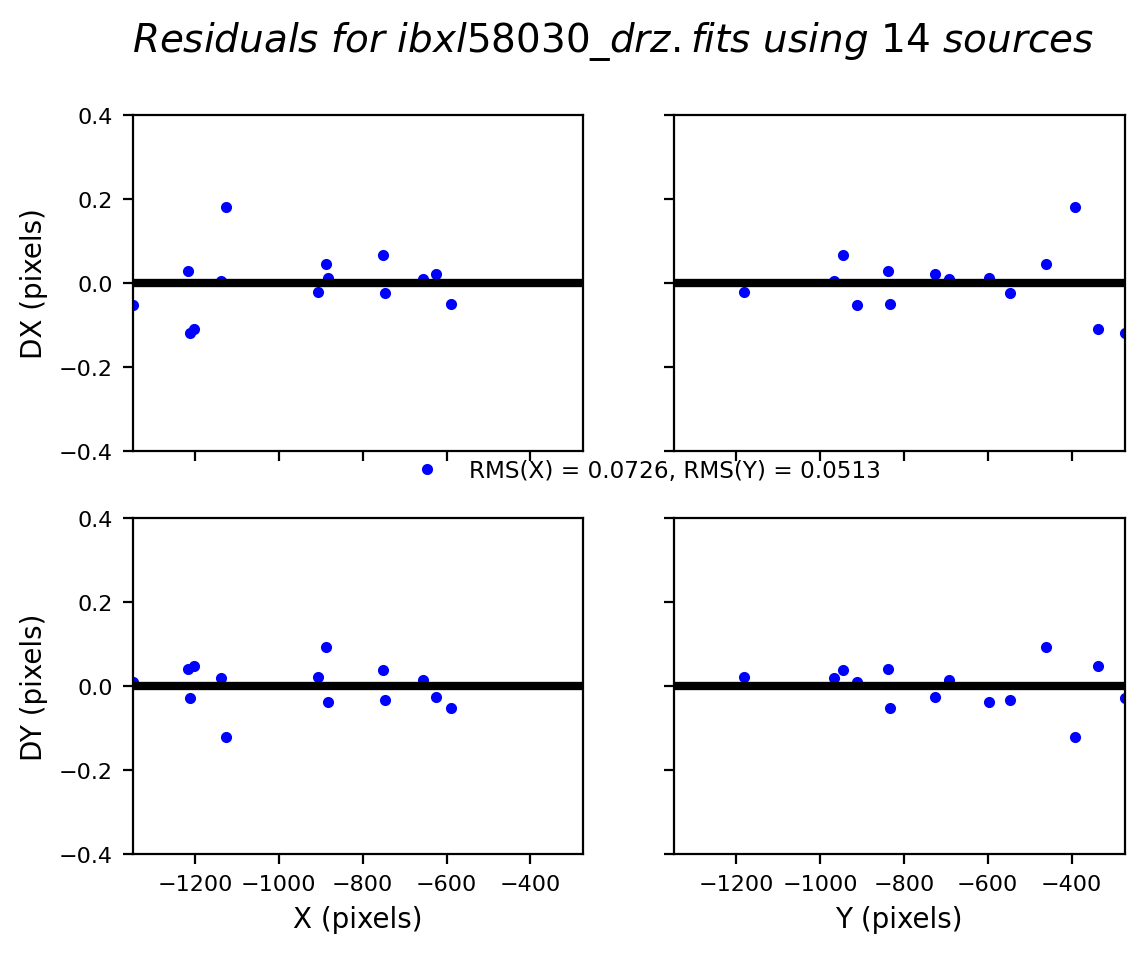

In [9]:
refcat = 'gaia_pm.cat'                    # Use the catalog with proper motion data

drz_files = sorted(glob.glob('*drz.fits'))

tweakreg.TweakReg(drz_files, 
                  imagefindcfg={'threshold': 4, 'conv_width': 4.5}, 
                  minobj=3,
                  shiftfile=True, 
                  outshifts='shift_drz.txt',
                  refcat=refcat,
                  searchrad=1,
                  ylimit=0.4, 
                  nclip=1,
                  updatehdr=False,       # change later when you verify the alignment works
                  interactive=False)
# clear_output()

In [10]:
# If the alignment is unsuccessful, stop the notebook
with open('shift_drz.txt', 'r') as shift:
    for line_number, line in enumerate(shift, start=1):
        if "nan" in line:
            raise ValueError(f'nan found in line {line_number} in shift file')

### 2.4 Inspect the shift file and fit quality <a id="fit_quality"></a>

In [11]:
# Read the shift file just created by tweakreg
# There are 7 columns including: filename, x-shift, y-shift, rotation, scale, x-RMS, and y-RMS
shift_table = Table.read('shift_drz.txt',
                         format='ascii.no_header', 
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

# Define the format for each column (excluding 'file').
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']

# Iterate over the columns 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'
for i, col in enumerate(shift_table.colnames[1:]):
    # Apply the format to the current column 
    shift_table[col].format = formats[i]
    
# Display the table in the notebook
shift_table

<Table length=9>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
ibxl50030_drz.fits   -0.91   -0.44   0.023 1.00045    0.05    0.08
ibxl51030_drz.fits   -0.10   -0.68 359.983 1.00022    0.04    0.04
ibxl52030_drz.fits   -0.51   -0.35   0.001 0.99971    0.04    0.02
ibxl53030_drz.fits   -0.25   -0.85 359.997 1.00019    0.05    0.05
ibxl54030_drz.fits   -0.20   -0.92 359.973 0.99921    0.03    0.05
ibxl55030_drz.fits   -0.01   -0.47 359.995 1.00018    0.05    0.04
ibxl56030_drz.fits   -0.15   -0.55 359.999 1.00018    0.14    0.06
ibxl57030_drz.fits    0.01    0.08   0.002 1.00005    0.04    0.05
ibxl58030_drz.fits    0.01    0.05 359.999 1.00000    0.07    0.05

Note that there are large residual rotation and scale terms in the shift file for several visits in the MAST data products.  These will be corrected when we run `TweakReg` an additional time and update the WCS in Section 2.6 below.

In [12]:
match_files = sorted(glob.glob('*_drz_catalog_fit.match'))
for f in match_files:
    input = ascii.read(f)
    print(f'Number of matches for {f} {len(input)}')

Number of matches for ibxl50030_drz_catalog_fit.match 9
Number of matches for ibxl51030_drz_catalog_fit.match 12
Number of matches for ibxl52030_drz_catalog_fit.match 8
Number of matches for ibxl53030_drz_catalog_fit.match 5
Number of matches for ibxl54030_drz_catalog_fit.match 7
Number of matches for ibxl55030_drz_catalog_fit.match 10
Number of matches for ibxl56030_drz_catalog_fit.match 5
Number of matches for ibxl57030_drz_catalog_fit.match 12
Number of matches for ibxl58030_drz_catalog_fit.match 14


Next we compare with the MAST WCS solutions, number of matches and fit RMS values. Since there are only 5 Gaia sources in Visits 53 and 56, these did not have a successful Gaia fit during MAST processing and instead were aligned to the next catalog in the priority list, GSC v2.4.2. (Currently the minimum number of matches for a successful fit is 6, but this will updated to 10 in summer 2024. 

In [13]:
wcstable

<Table length=9>
     FILENAME      DETECTOR ... RMS_RA_pix RMS_DEC_pix
      str18          str2   ...  float64     float64  
------------------ -------- ... ---------- -----------
ibxl50030_drz.fits       IR ...       0.52        0.41
ibxl51030_drz.fits       IR ...       0.57        0.67
ibxl52030_drz.fits       IR ...       0.46        0.51
ibxl53030_drz.fits       IR ...       0.43        0.59
ibxl54030_drz.fits       IR ...       0.57        0.69
ibxl55030_drz.fits       IR ...       0.49        0.68
ibxl56030_drz.fits       IR ...       0.48        0.73
ibxl57030_drz.fits       IR ...       0.05        0.05
ibxl58030_drz.fits       IR ...       0.09        0.05

### 2.5 Overplot matched sources and inspect fit residuals <a id="overplot"></a>

Here we overplot the HST sources which were successfully matched with Gaia eDR3 and we look at the astrometric fit residual PNG plots.

While we inspect only two visits (52 and 53) at a time, and additional visits may be uncommented in the cell below. 

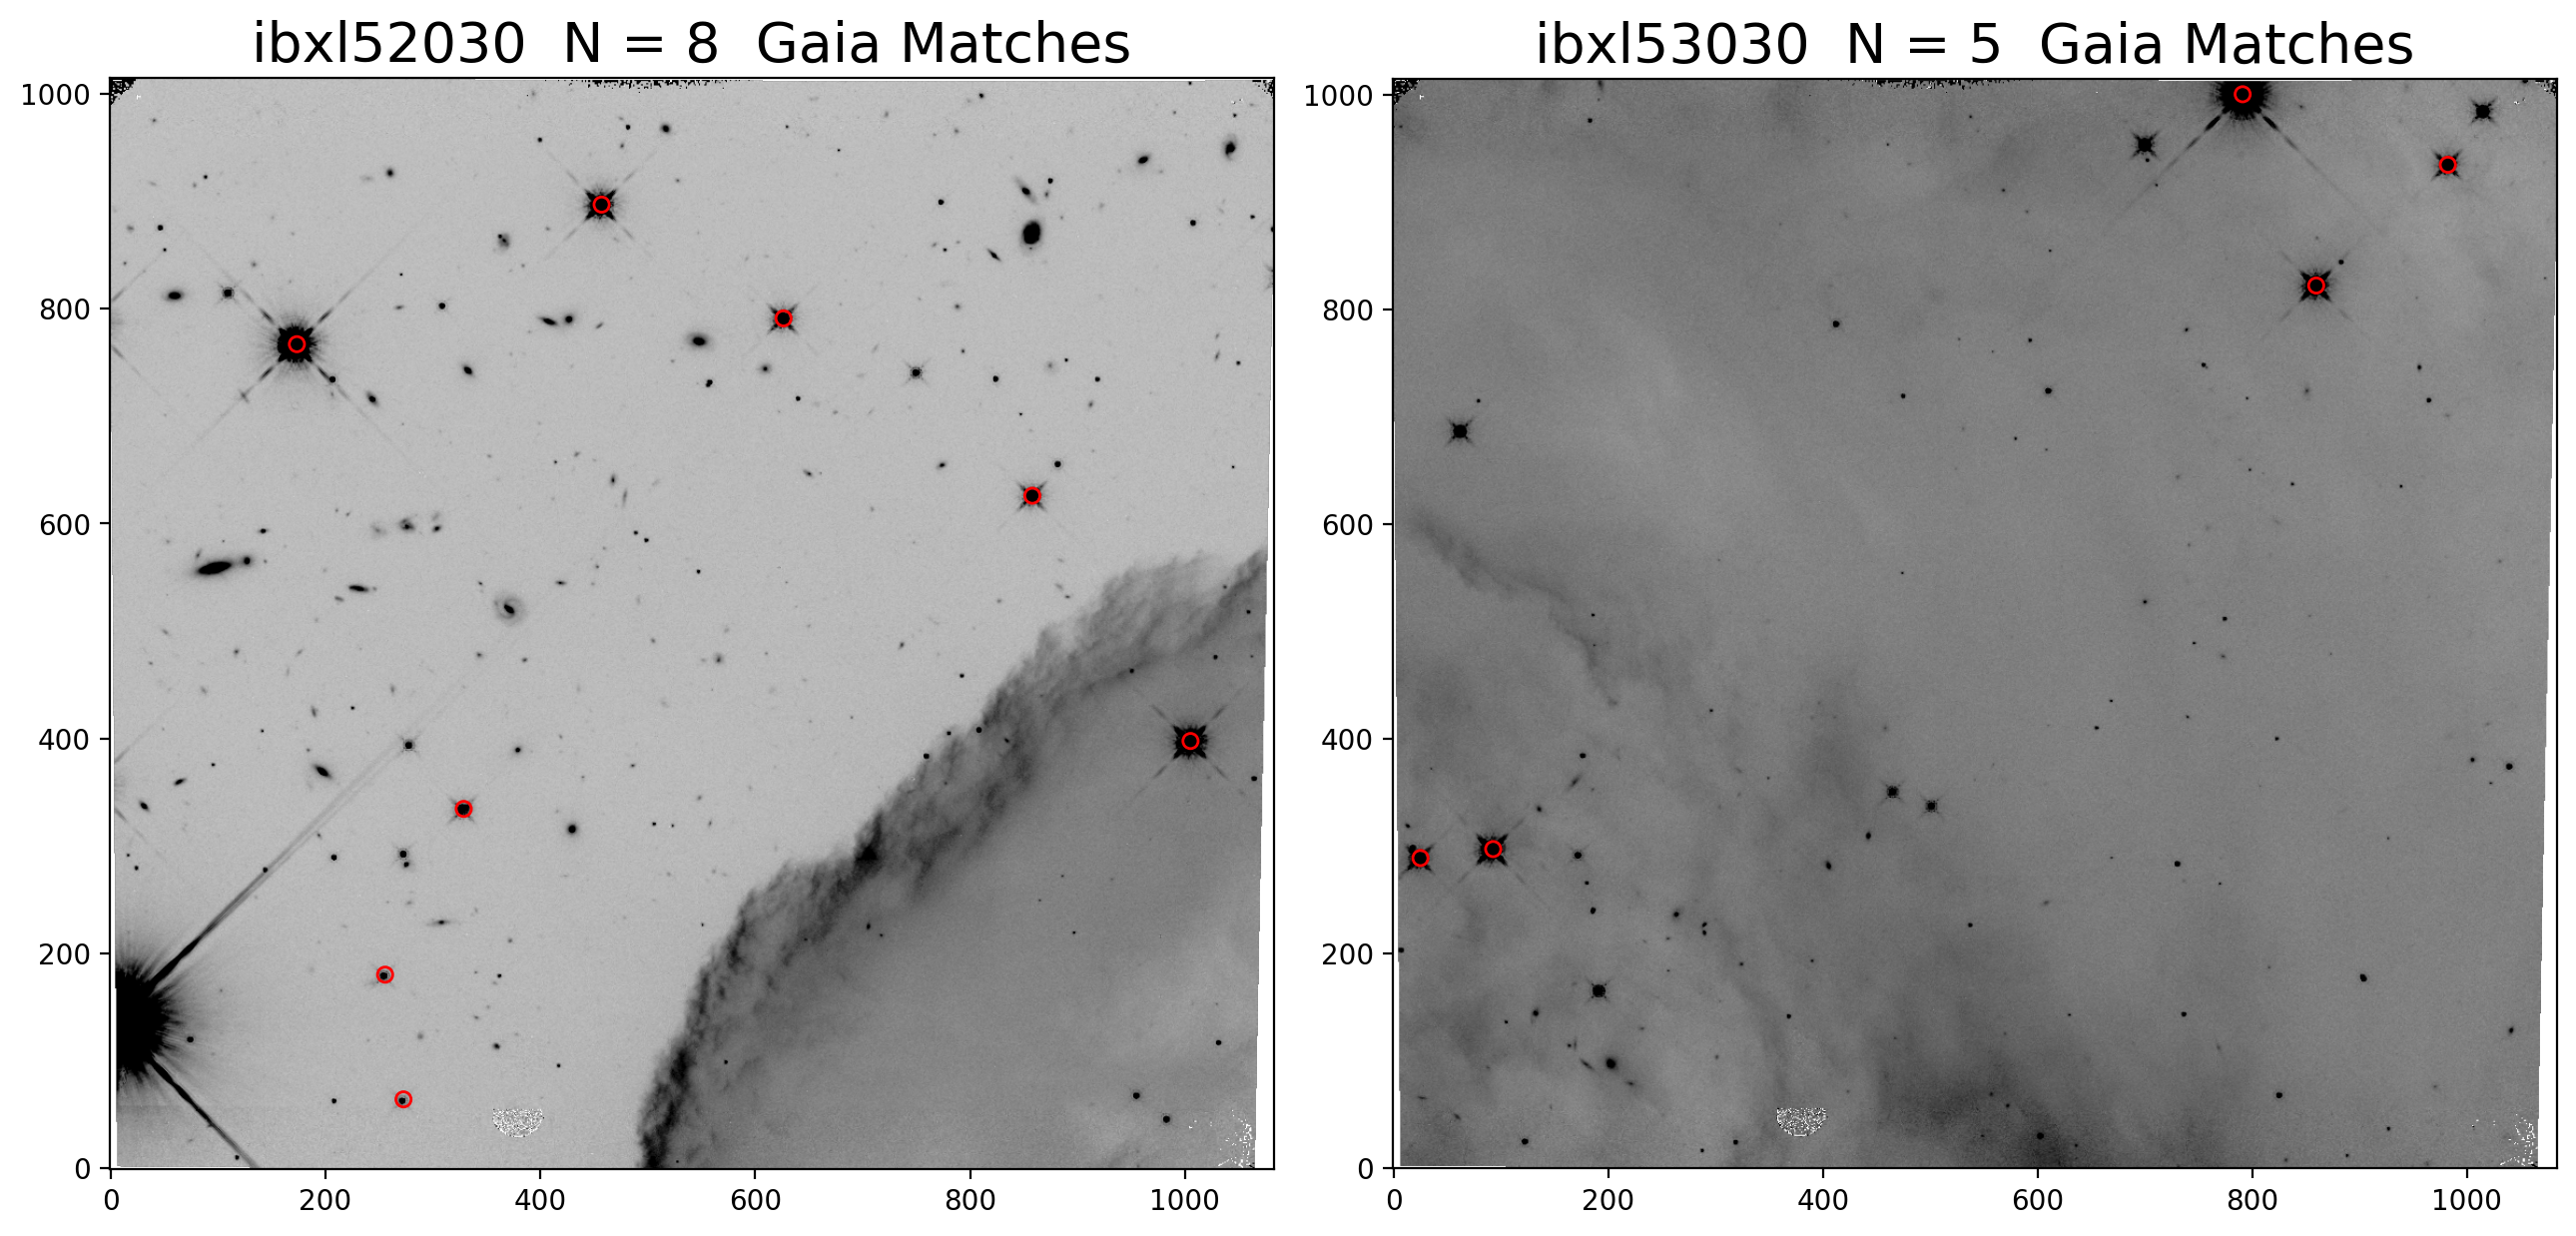

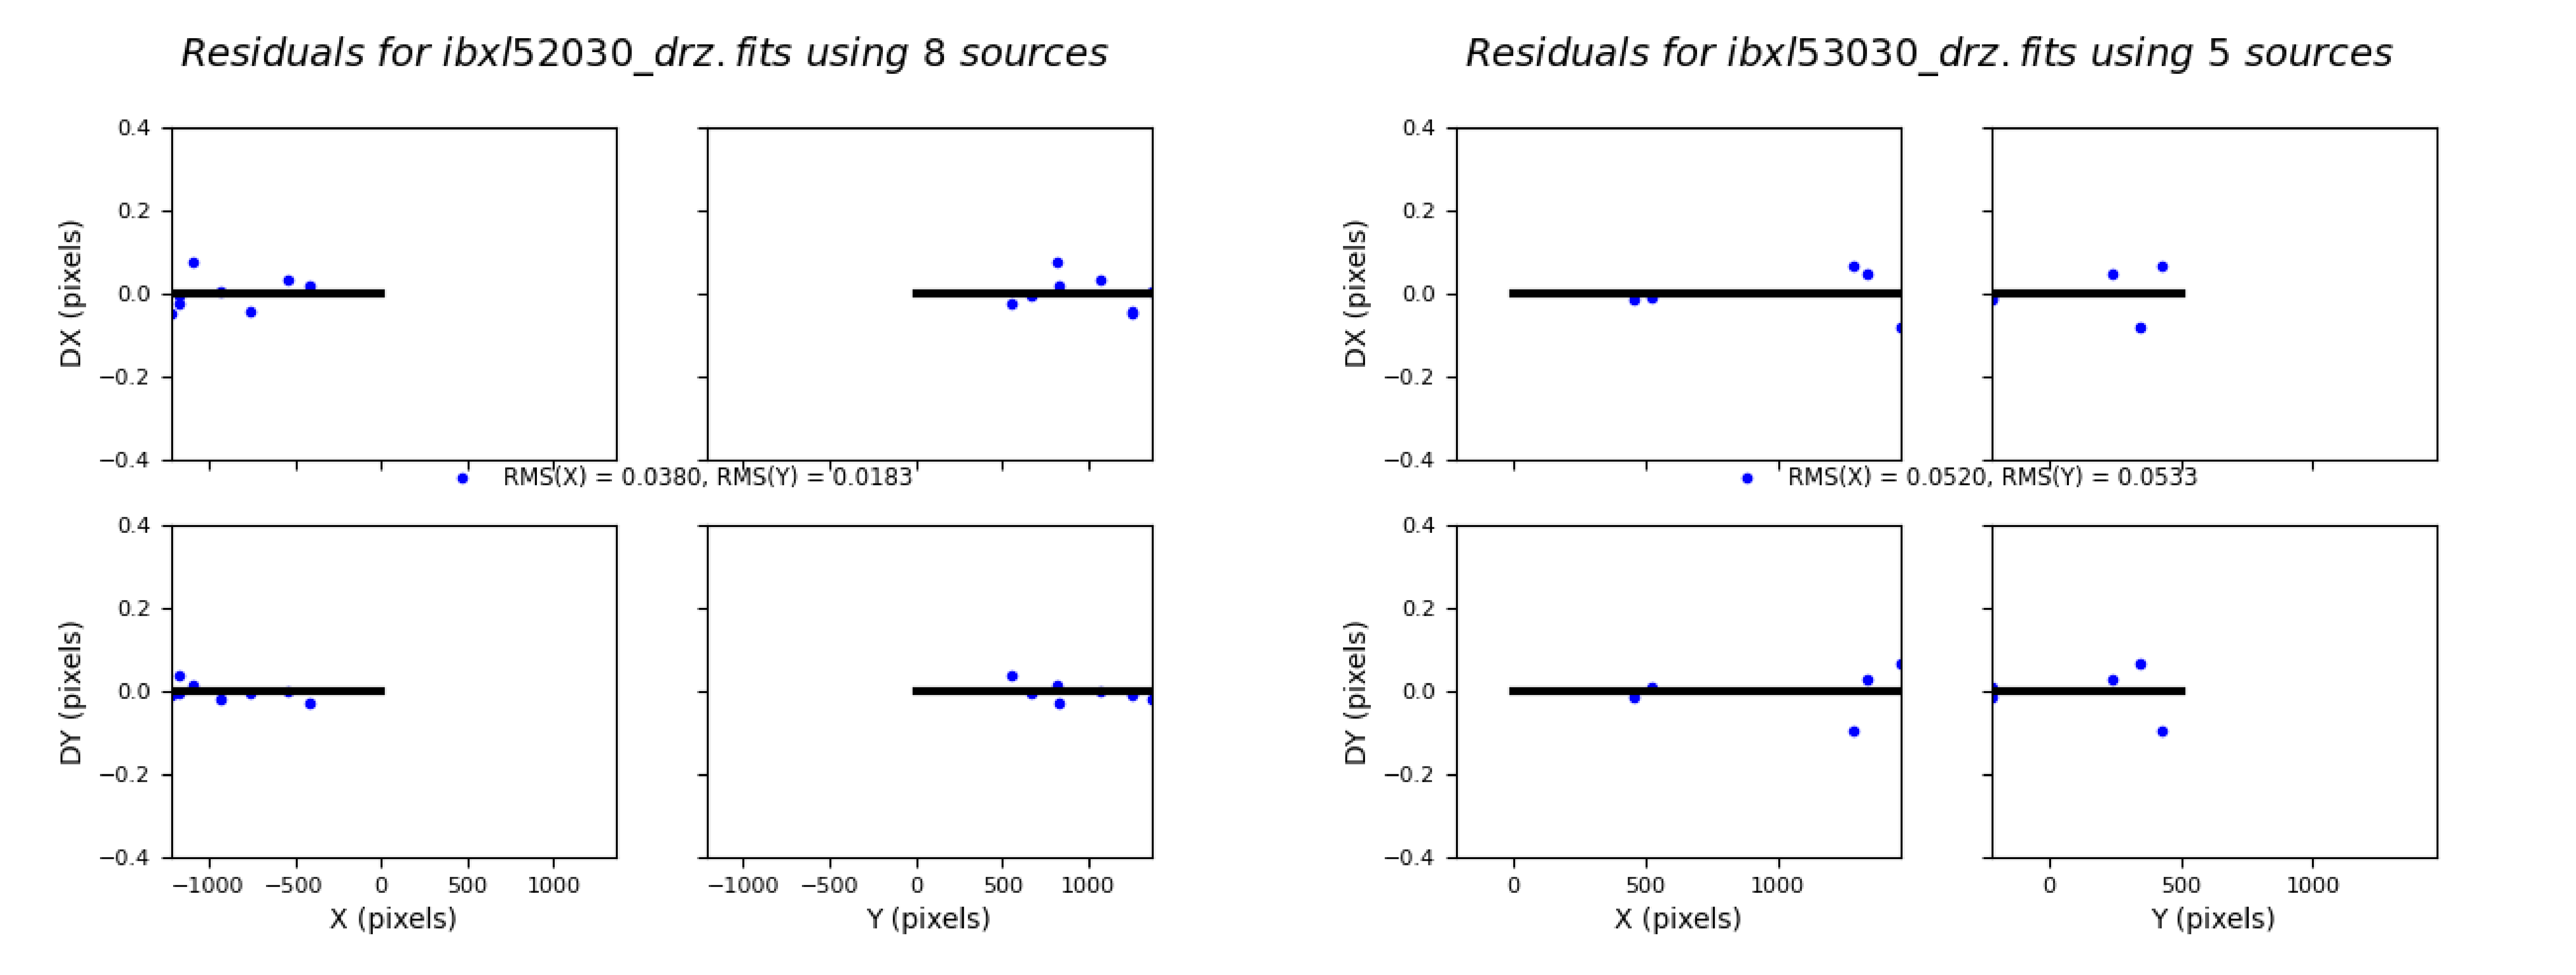

In [14]:
# Define the rootnames for the two FITS files to be compared
# Uncomment the pairs you want to use

# rootname_A = 'ibxl50030'
# rootname_B = 'ibxl51030'
rootname_A = 'ibxl52030'
rootname_B = 'ibxl53030'
# rootname_A = 'ibxl54030'
# rootname_B = 'ibxl55030'
# rootname_A = 'ibxl56030'
# rootname_B = 'ibxl57030'
# rootname_A = 'ibxl57030'
# rootname_B = 'ibxl58030'

# Create subplots with 1 row and 2 columns
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 10))

# Open the FITS files and extract the data from the 'SCI' extension
data_a = fits.open(rootname_A+'_drz.fits')['SCI', 1].data
data_b = fits.open(rootname_B+'_drz.fits')['SCI', 1].data

# Display the images in grayscale with a stretch from 0 to 2 
ax1.imshow(data_a, cmap='Greys', origin='lower', vmin=0, vmax=2)
ax2.imshow(data_b, cmap='Greys', origin='lower', vmin=0, vmax=2)

# Read the matching catalog files for both rootnames
match_tab_a = ascii.read(rootname_A+'_drz_catalog_fit.match')
match_tab_b = ascii.read(rootname_B+'_drz_catalog_fit.match')

# Extract x and y coordinates from the matching catalogs
x_coord_a, y_coord_a = match_tab_a['col11'], match_tab_a['col12']
x_coord_b, y_coord_b = match_tab_b['col11'], match_tab_b['col12']

# Plot the coordinates on the images with red circles
ax1.scatter(x_coord_a, y_coord_a, s=30, edgecolor='r', facecolor='None')
ax2.scatter(x_coord_b, y_coord_b, s=30, edgecolor='r', facecolor='None')

# Set the titles for the subplots, including the number of matches
ax1.set_title(rootname_A+f'  N = {len(match_tab_a)}  Gaia Matches', fontsize=20)
ax2.set_title(rootname_B+f'  N = {len(match_tab_b)}  Gaia Matches', fontsize=20)
fig.tight_layout()

# Load, display, and inspect fit residual PNG files
img_A = mpimg.imread(f'residuals_{rootname_A}_drz.png')
img_B = mpimg.imread(f'residuals_{rootname_B}_drz.png')

# Create subplots for the residual images
fig, axs = plt.subplots(1, 2, figsize=(20, 10), dpi=200)
axs[0].imshow(img_A)
axs[1].imshow(img_B)

# Remove unnecessary axis from the residual images
axs[0].axis('off') 
axs[1].axis('off')

# Adjust layout to minimize margins and display plots
fig.tight_layout()
plt.show()

### 2.6 Rerun `TweakReg` and update the header WCS <a id="updatehdr"></a>

Once we are happy with the alignment, we run `TweakReg` again with the same parameters but with the `updatehdr=True`.

In [15]:
refcat = 'gaia_pm.cat'    # Use the catalog with proper motion data

tweakreg.TweakReg(drz_files, 
                  imagefindcfg={'threshold': 4, 'conv_width': 4.5}, 
                  minobj=4,
                  shiftfile=False, 
                  refcat=refcat,
                  searchrad=1,
                  ylimit=0.4, 
                  nclip=1,
                  updatehdr=True,       # update header
                  interactive=False)
clear_output()

### 2.7 Run `TweakBack` to propogate the WCS to the FLT files <a id="tweakback"></a>

Finally, we run `Tweakback` on the aligned DRZ files to propogate the updated WCS information back to the FLT files.

In [16]:
for f in drz_files:
    tb_input = f+'[sci,1]'
    with fits.open(f) as hdu:
        tweakback.apply_tweak(tb_input, orig_wcs_name=hdu[1].header['WCSNAME'])
    
clear_output()

## 3. Compare  `skymethod` options in AstroDrizzle <a id="compare"></a>

Now that the FLT files contain the updated WCS solutions, we explore different algorithms for estimating the sky.

### 3.1 `skymethod = 'localmin'` <a id="localmin"></a>

When using `AstroDrizzle` to compute the sky in each frame, 'localmin' will compute a common sky value for all chips of a given exposure, using the minimum sky value from all chips. This process is repeated for each input image. This algorithm is recommended when images are dominated by blank sky instead of extended, diffuse sources.

See [readthedocs](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky) for more details on sky subtraction options.

In the command below, the aligned FLT frames are sky subtracted and drizzled together. 

Because the WFC3/IR data products are already cleaned of cosmic rays during calwf3 processing, cosmic-ray rejection is turned off in AstroDrizzle by setting the parameters `driz_separate`, `median`, `blot`, and `driz_cr` to 'False'. Note that `final_bits=16` means only the stable hot pixels are treated as good. 

In [17]:
sky = 'localmin'
astrodrizzle.AstroDrizzle('*flt.fits', 
                          output='f160w_localmin',
                          preserve=False, 
                          context=False,
                          skymethod=sky, 
                          driz_separate=False, median=False, blot=False, driz_cr=False, # CR-rej turned off
                          final_bits='16',
                          final_wcs=True, 
                          final_rot=257.)
clear_output()

### 3.2 `skymethod = 'match'` <a id="match"></a>

When `skymethod` is set to ‘match’, differences in sky values between images in common sky regions will be computed. Thus, sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to and reported as 0. This setting “equalizes” sky values between the images in large mosaics. 

This is the **recommended** setting for images containing diffuse sources (e.g., galaxies, nebulae) covering significant parts of the image.

In [18]:
sky = 'match'
astrodrizzle.AstroDrizzle('*flt.fits', 
                          output='f160w_match',
                          preserve=False, 
                          context=False,
                          skymethod=sky, 
                          driz_separate=False, median=False, blot=False, driz_cr=False, # CRREJ=None
                          final_bits='16',
                          final_wcs=True, 
                          final_rot=257.)
clear_output()

### 3.3 `skymethod = 'globalmin+match'` <a id="globalminmatch"></a>

When `skymethod` is set to ‘globalmin+match', AstroDrizzle will first find a minimum “global” sky value in all input images and then use the ‘match’ method to equalize sky values between images.

In [19]:
sky = 'globalmin+match'
astrodrizzle.AstroDrizzle('*flt.fits', 
                          output='f160w_globalmin_match',
                          preserve=False, 
                          context=False,
                          skymethod=sky, 
                          driz_separate=False, median=False, blot=False, driz_cr=False, # CRREJ=None
                          final_bits='16',
                          final_wcs=True, 
                          final_rot=257.)
clear_output()

### 3.4 `skymethod = 'globalmin'` <a id="globalmin"></a>

When `skymethod` is set to ‘globalmin’, a common sky value will be computed for all exposures. AstroDrizzle will compute sky values for each chip/image extension, find the minimum sky value from all the exposures, and then subtract that minimum sky value from all chips in all images. 

This method may be useful when input images already have matched background values.

In [20]:
sky = 'globalmin'
astrodrizzle.AstroDrizzle('*flt.fits', 
                          output='f160w_globalmin',
                          preserve=False, 
                          context=False,
                          skymethod=sky, 
                          driz_separate=False, median=False, blot=False, driz_cr=False, # CRREJ=None
                          final_bits='16',
                          final_wcs=True, 
                          final_rot=257.)
clear_output()

## 4. Compare the MDRIZSKY values for each method <a id="mdrizsky"></a>

Below we provide a gif comparing the upper portion of the final drizzled image. We cycle through three drizzled images produced using different `skymethod` algorithms:  

![The top of the horsehead nebula is shown in grayscale with a stretch of about -0.4 to 2 and the animated gif transitions between displaying the "localmin", "match", and "globalmin+match" sky methods from astrodrizzle. Localmin looks the worst with unmatched backgrounds in the top left and right corners where the outline of separate pointings (dithers) are apparent.](labeled_local_globalmatch_match.gif)

Next we print the sky values computed for each image using the four different methods.

In [21]:
mdrizsky_val = pandas.DataFrame({'rootname': fits.getdata('f160w_globalmin_drz_sci.fits', 1)['rootname'],
                                 'local': fits.getdata('f160w_localmin_drz_sci.fits', 1)['mdrizsky'],
                                 'globalmin': fits.getdata('f160w_globalmin_drz_sci.fits', 1)['mdrizsky'],
                                 'globalmin_match': fits.getdata('f160w_globalmin_match_drz_sci.fits', 1)['mdrizsky'],
                                 'match': fits.getdata('f160w_match_drz_sci.fits', 1)['mdrizsky']})
mdrizsky_val

rootname     local  globalmin  globalmin_match     match
0   ibxl50clq  1.150338   0.795985         0.799595  0.032796
1   ibxl50cqq  1.162587   0.795985         0.795926  0.029128
2   ibxl51eoq  1.173177   0.795985         0.810412  0.043613
3   ibxl51etq  1.170005   0.795985         0.799362  0.032563
4   ibxl52k0q  0.801102   0.795985         0.801102  0.034303
5   ibxl52k5q  0.795985   0.795985         0.789244  0.022445
6   ibxl53kxq  1.202108   0.795985         0.813771  0.046972
7   ibxl53l9q  1.183192   0.795985         0.793237  0.026439
8   ibxl54bgq  1.169292   0.795985         0.792419  0.025620
9   ibxl54blq  1.162808   0.795985         0.787202  0.020403
10  ibxl55f0q  1.005760   0.795985         0.784272  0.017473
11  ibxl55f5q  1.008806   0.795985         0.784592  0.017793
12  ibxl56huq  1.362592   0.795985         0.796189  0.029390
13  ibxl56i2q  1.361517   0.795985         0.791313  0.024514
14  ibxl57adq  1.132586   0.795985         0.774923  0.008124
15  ibxl57aiq  1.119377   0.795985         0.774029  0.007230
16  ibxl58sqq  0.804761   0.795985         0.768317  0.001518
17  ibxl58svq  0.799282   0.795985         0.766799  0.000000

These computed sky values can be visualized in the plot below. To reiterate, the MDRIZSKY keyword reports the value subtracted from each FLC image prior to drizzling, and not the sky level itself. Thus the values for `skymethod='match'` are close to zero. 

We also note that varying background levels across the individual tiles result in inaccurate sky background determination when `skymethod='localmin'` and thus a mismatched sky in the final mosaic.

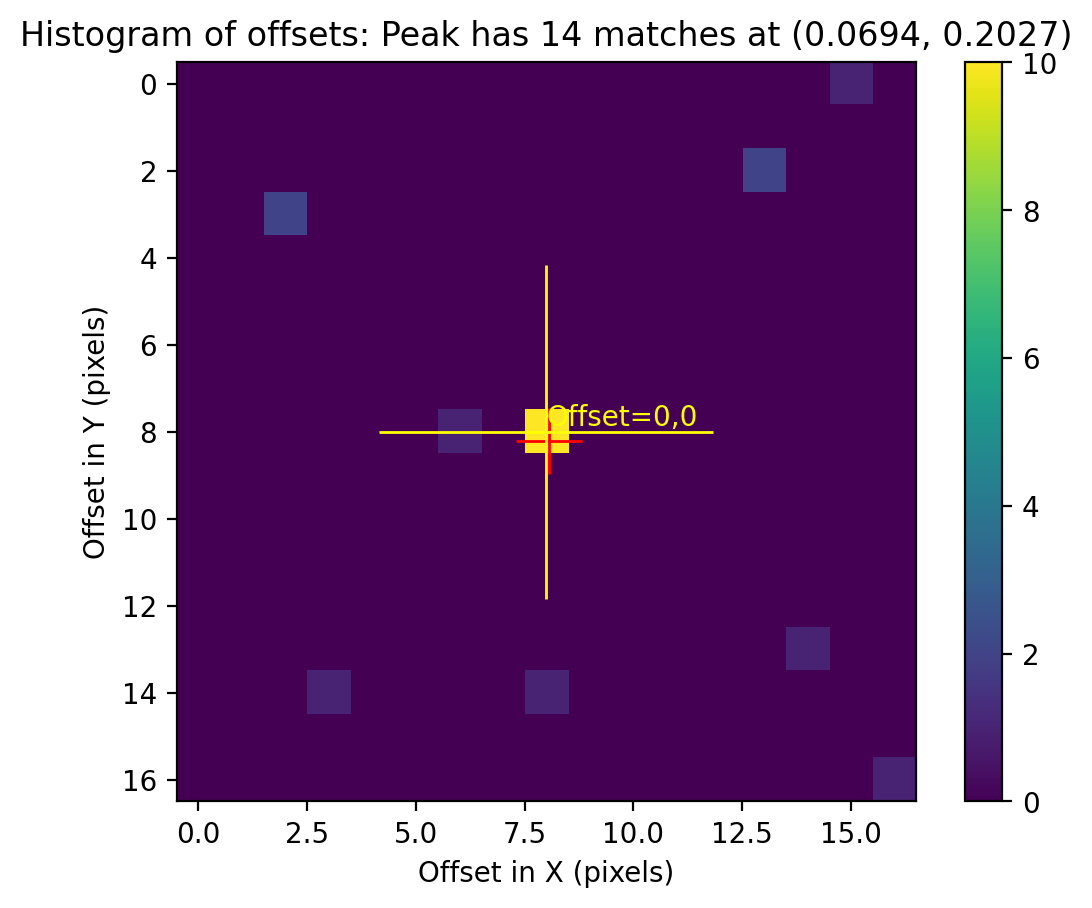

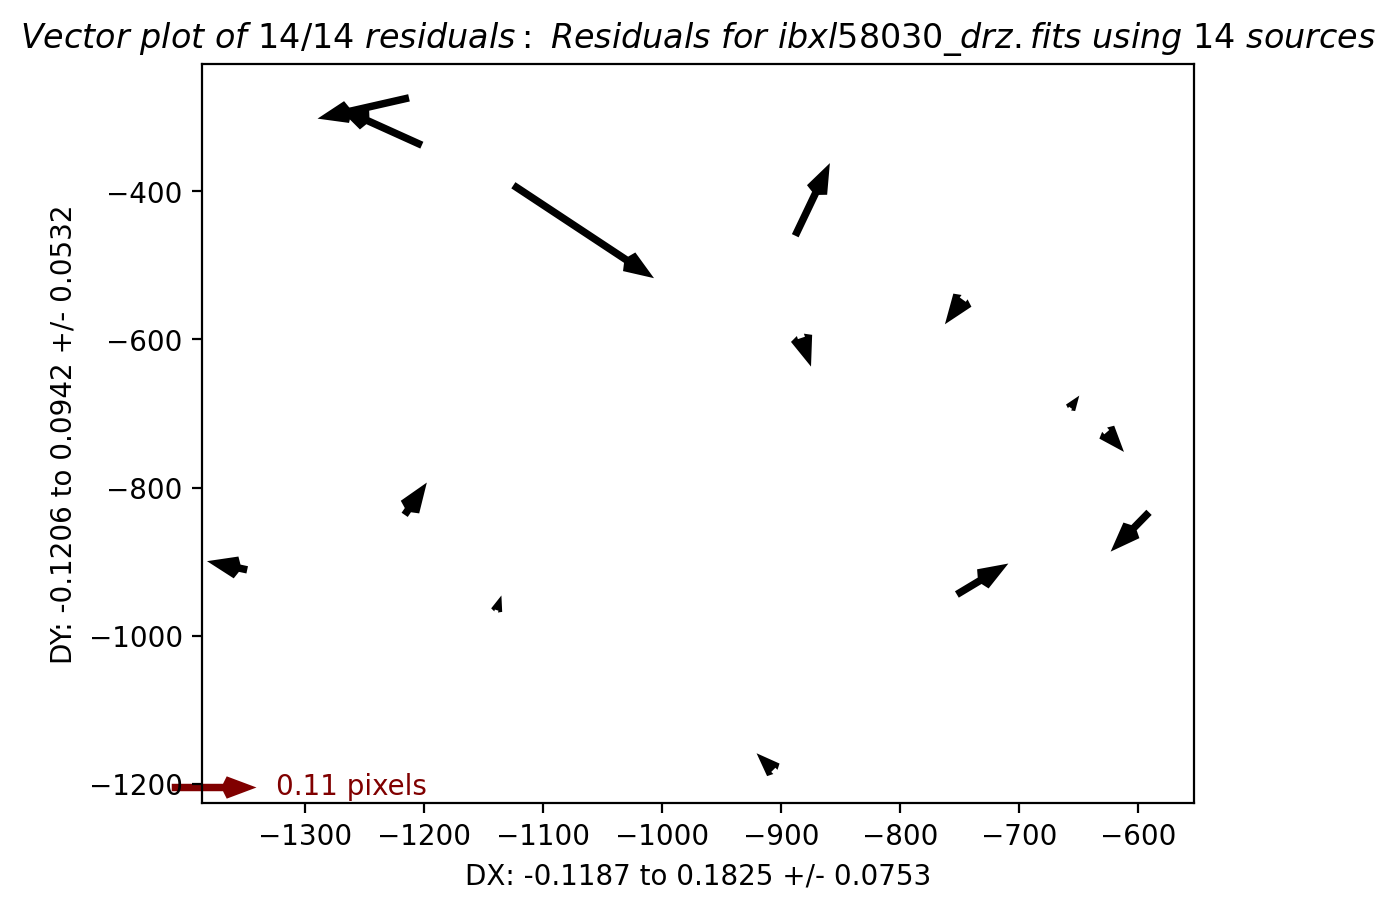

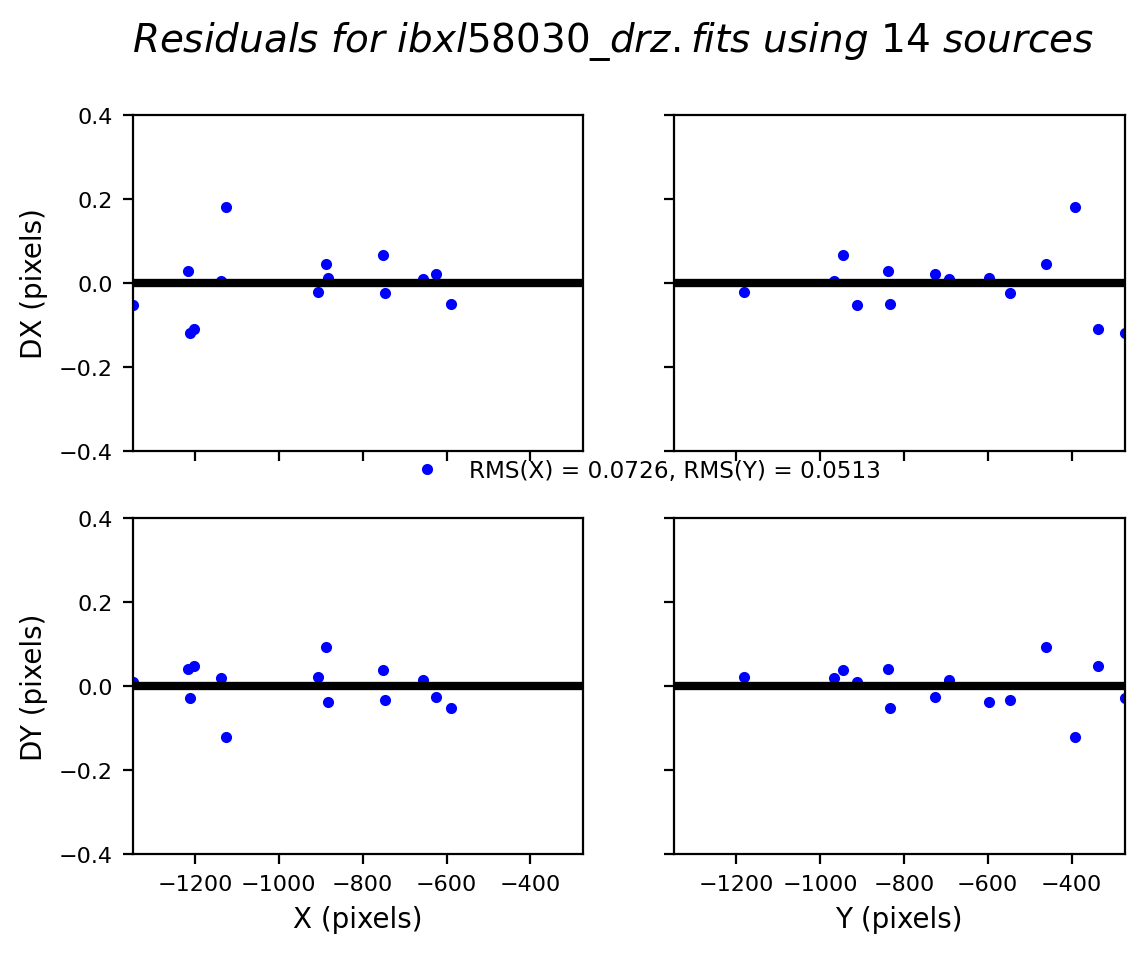

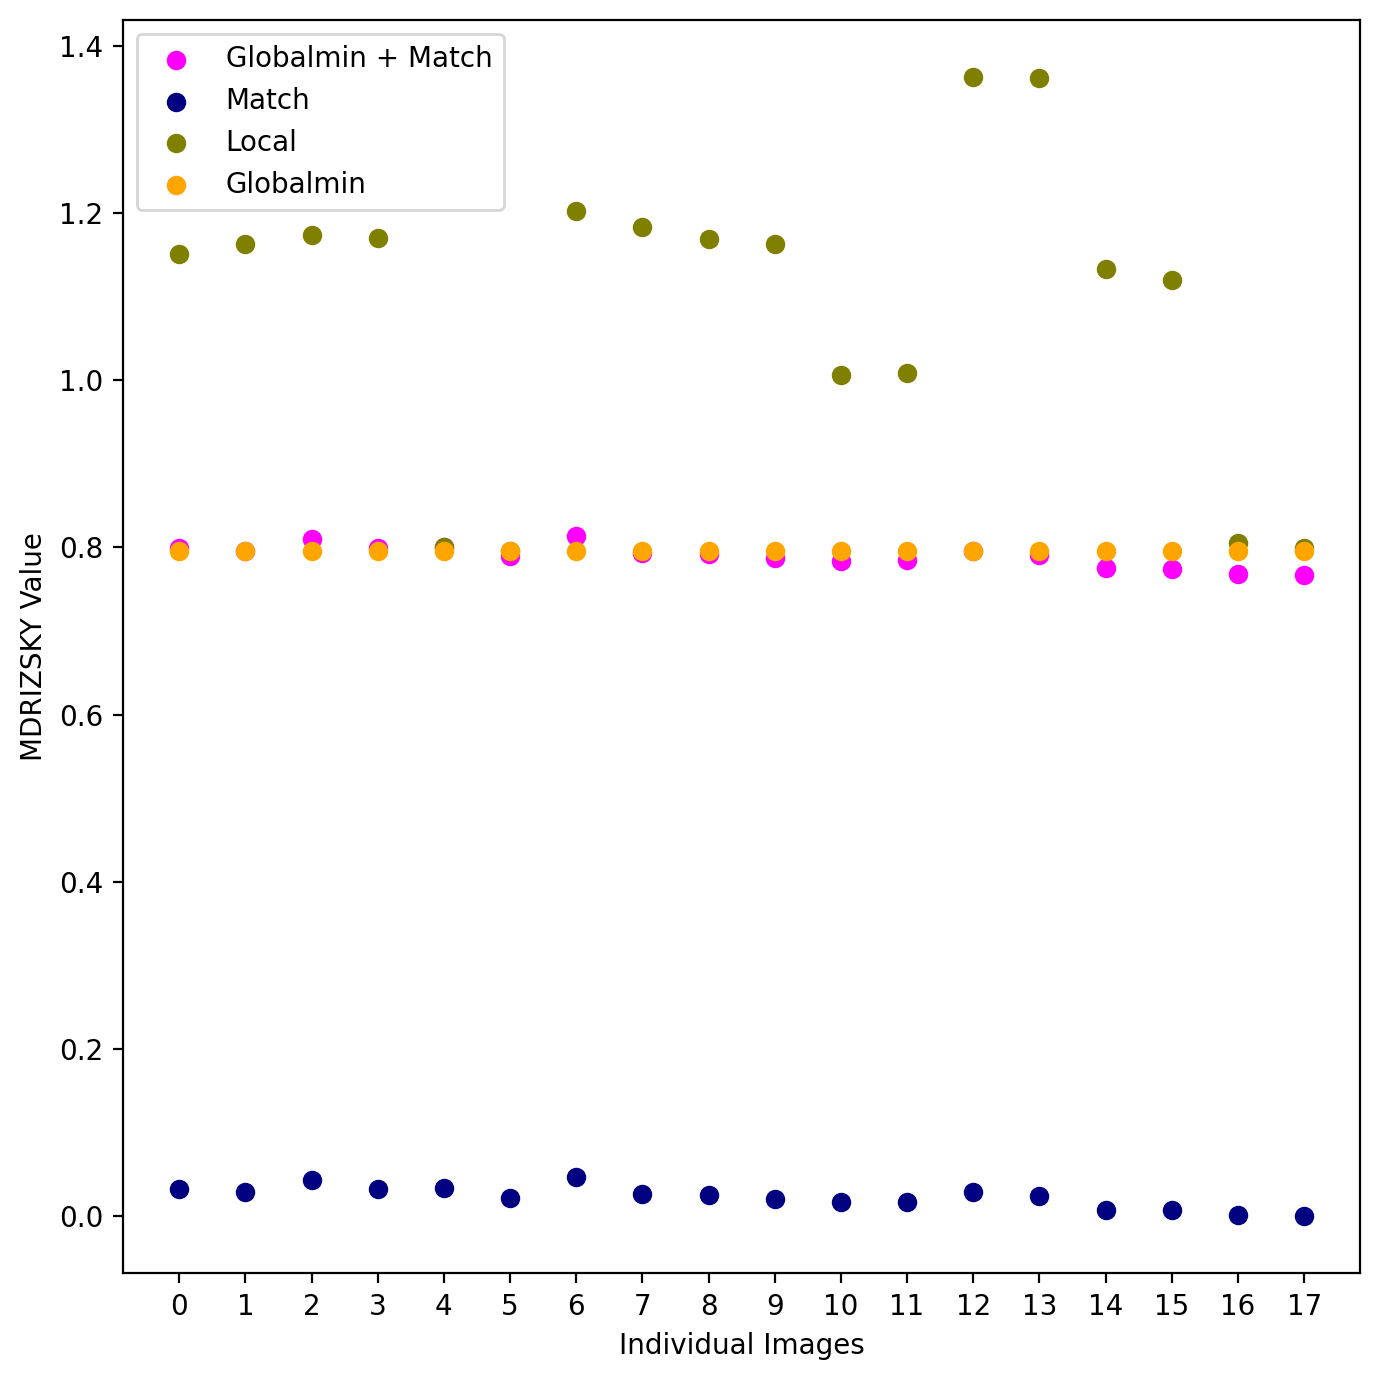

In [22]:
index = mdrizsky_val.index.tolist()
globalmin = list(mdrizsky_val['globalmin'])
globalmin_match = list(mdrizsky_val['globalmin_match'])
match = list(mdrizsky_val['match'])
local = list(mdrizsky_val['local'])

# Plotting code: 
fig = plt.figure(figsize=[7, 7])
plt.scatter(index, globalmin_match, color='magenta', label='Globalmin + Match')
plt.scatter(index, match, color='navy', label='Match')
plt.scatter(index, local, color='olive', label='Local')
plt.scatter(index, globalmin, color='orange', label='Globalmin')
plt.xlabel('Individual Images')
plt.ylabel('MDRIZSKY Value')
plt.legend(loc='best')
plt.xticks(index)
plt.tight_layout()
plt.show()

## 5. Display the 'sky matched' science mosaic and weight image <a id="display"></a>

Finally, we display the science and weight images for the combined mosaic.

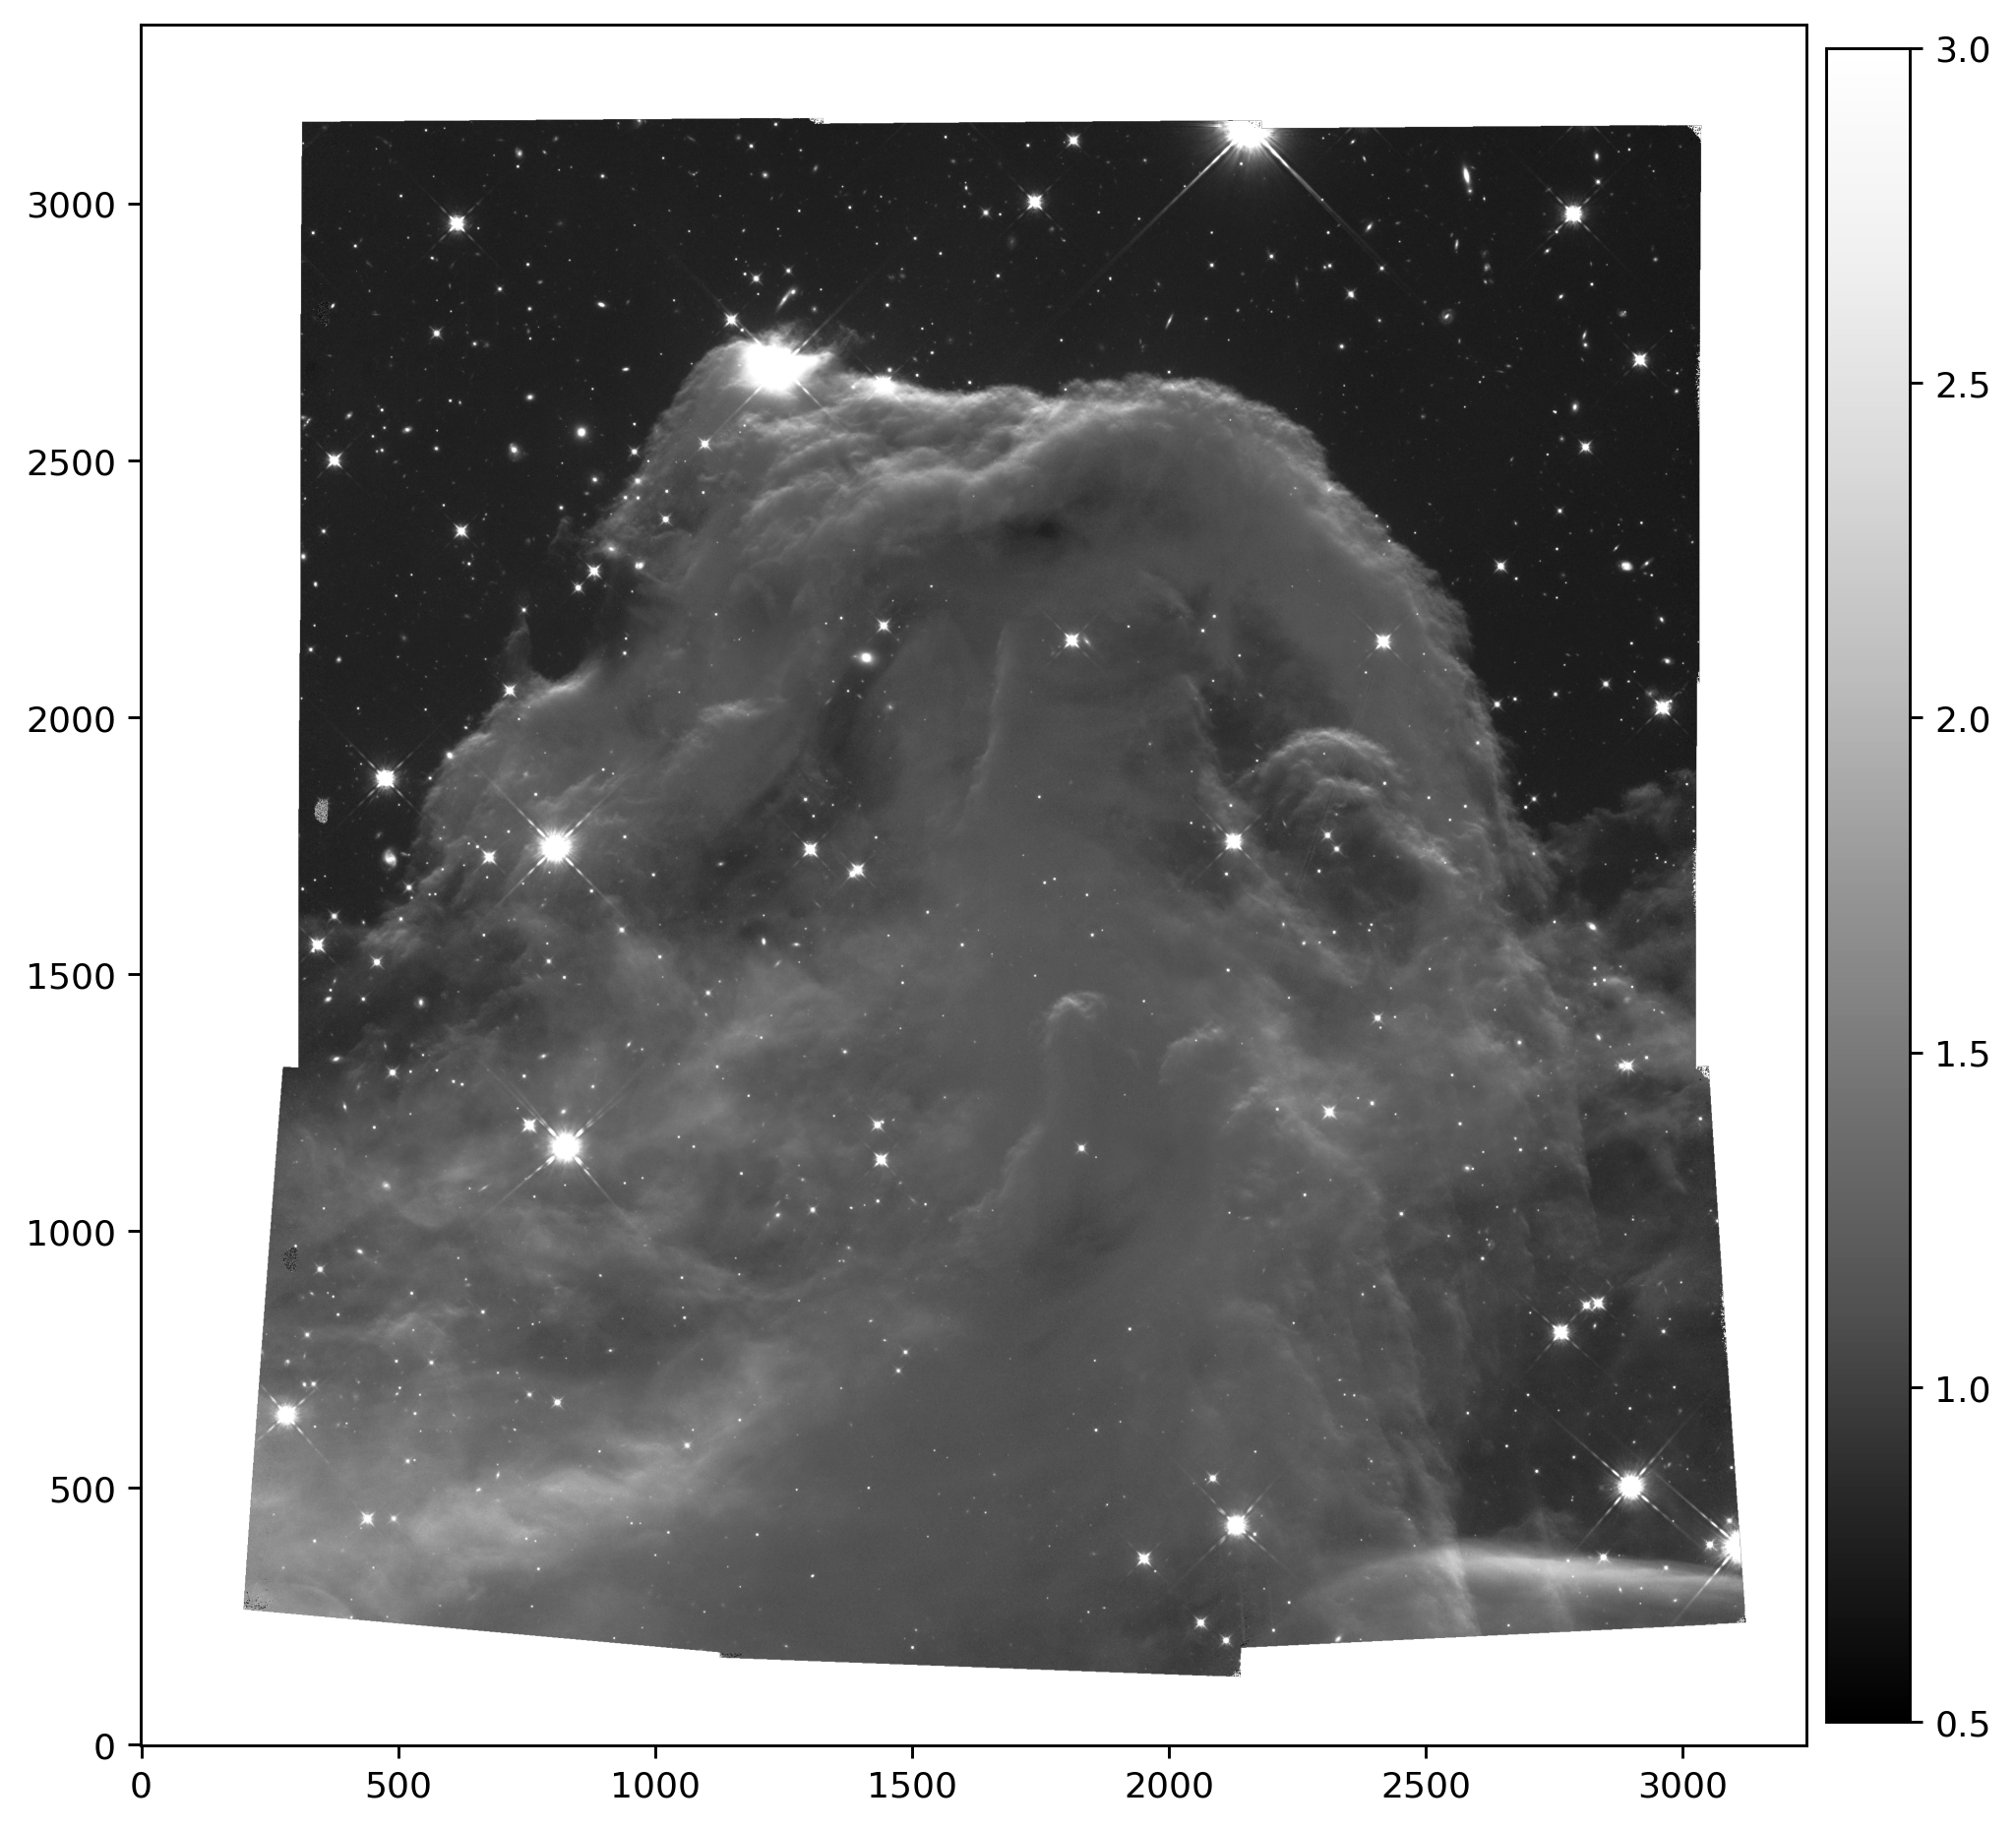

In [23]:
sci = fits.getdata('f160w_match_drz_sci.fits')
fig = plt.figure(figsize=(10, 10), dpi=130)
plt.imshow(sci, vmin=0.5, vmax=3, cmap='Greys_r', origin='lower')
plt.colorbar(shrink=0.85, pad=0.01)
plt.show()

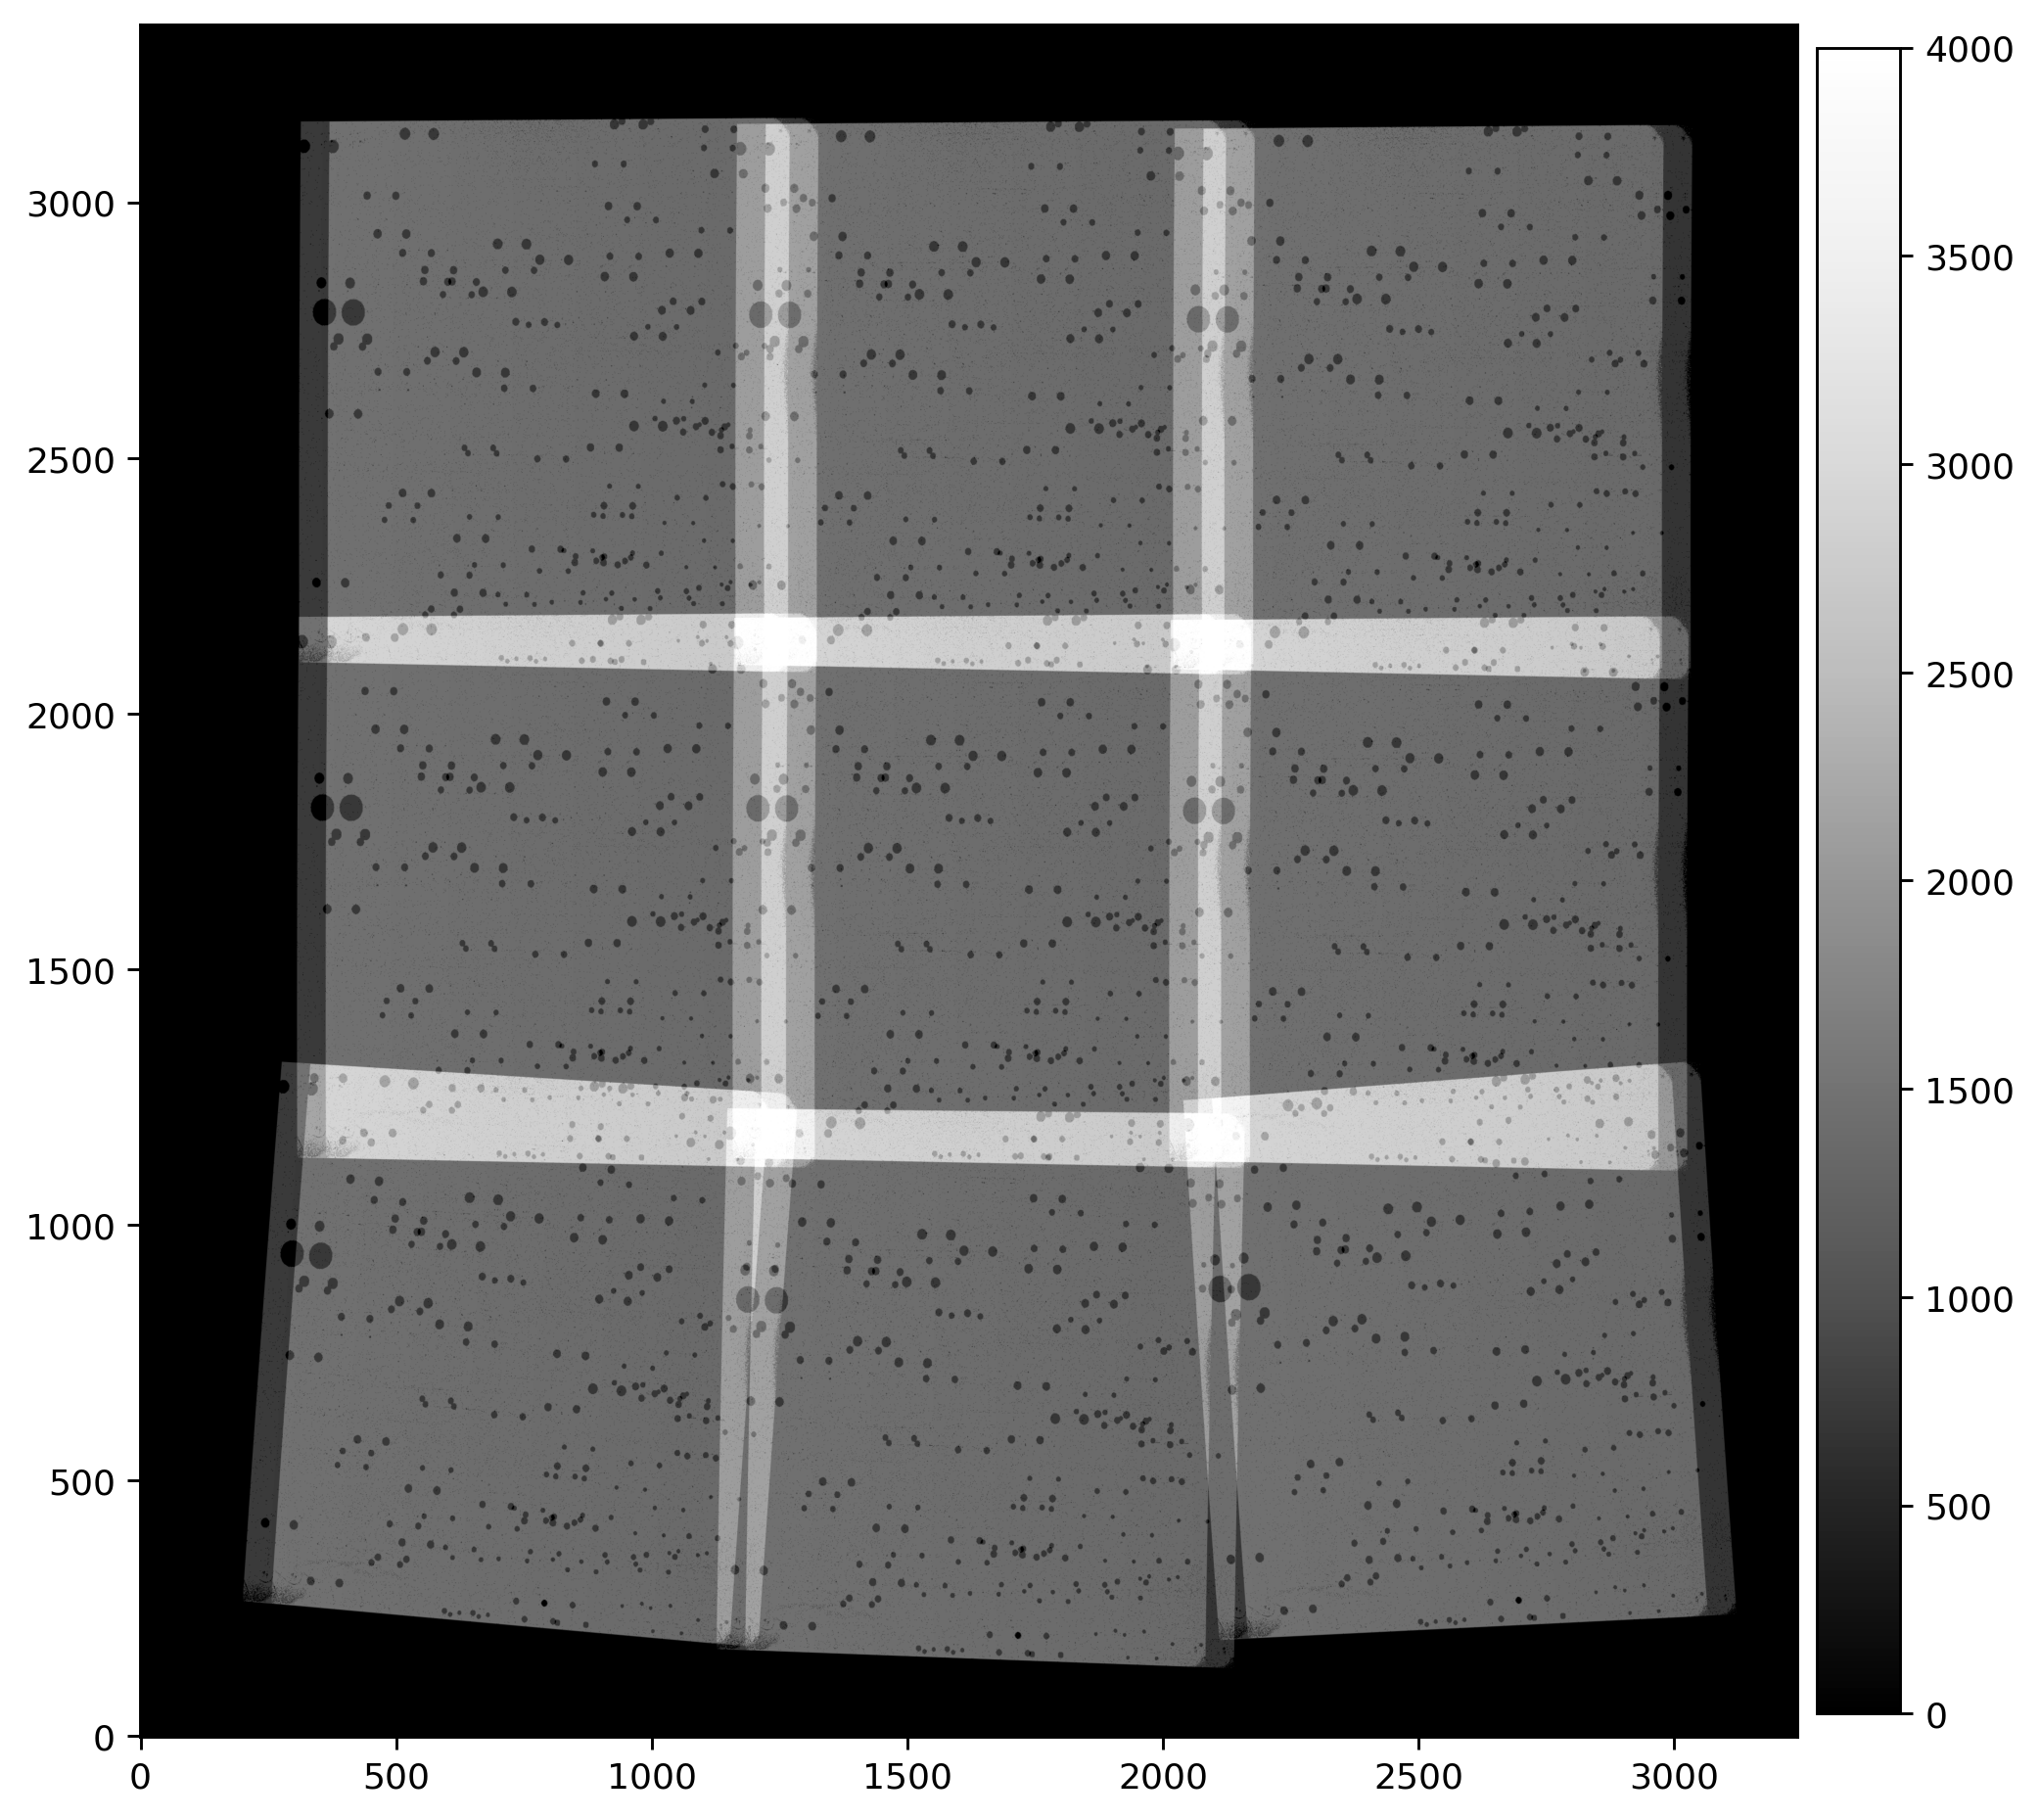

In [24]:
sci = fits.getdata('f160w_match_drz_wht.fits')
fig = plt.figure(figsize=(10, 10), dpi=130)
plt.imshow(sci, vmin=0, vmax=4000, cmap='Greys_r', origin='lower')
plt.colorbar(shrink=0.85, pad=0.01)
plt.show()

## 6. Conclusion <a id="conclusion"></a>
Thank you for going through this notebook. You should now have all the necessary tools for assessing the <br>
appropriate `skymethod` parameter to use when combining images. After completing this notebook you <br>
should be more familiar with:<br>
&nbsp;&nbsp;&nbsp;&nbsp;• How to effectively use `astroquery` to download FLT and DRZ files. <br>
&nbsp;&nbsp;&nbsp;&nbsp;• Checking the WCS of images and aligning them to a reference catalog with `TweakReg`. <br>
&nbsp;&nbsp;&nbsp;&nbsp;• Combining data with `AstroDrizzle` taking into account the `skymethod` <br>
<br>
**Congratulations, you have completed the notebook!**
   

## Additional Resources <a id="resources"></a>

* [DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac)
* [HST Help Desk](https://stsci.service-now.com/hst)
* [Other DrizzlePac Notebooks](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/DrizzlePac)

## About this Notebook <a id="about"></a>

Created:  14 Dec 2018; C. Martlin & J. Mack <br>
Updated:  16 Nov 2023; K. Huynh & J. Mack       <br>
Updated:  23 Jul 2024; J. Mack & B. Kuhn   <br>

**Source:** https://github.com/spacetelescope/hst_notebooks <br>

## Citations <a id="citations"></a>
If you use Python packages for published research, please cite the authors. Follow these links for more <br>
information about citing packages such as `astropy`, `astroquery`, `matplotlib`, `pandas`, etc.: <br>
* [Citing `astropy`](https://www.astropy.org/acknowledging.html) <br>
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) <br>
* [Citing `drizzlepac`](https://zenodo.org/records/6325653)<br>
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html) <br>
* [Citing `numpy`](https://numpy.org/citing-numpy/) <br>
* [Citing `pandas`](https://pandas.pydata.org/about/citing.html)<br>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 